# Non-linear classification

In [6]:
# the model design is adapted from Piotr Skalski code. 
# https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb

## Outline:

1. Working on toy double moon data and crafting multi-layer perceptron

2. Implementing a simple spam detector using SMS SPAM Dataset

In [3]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline


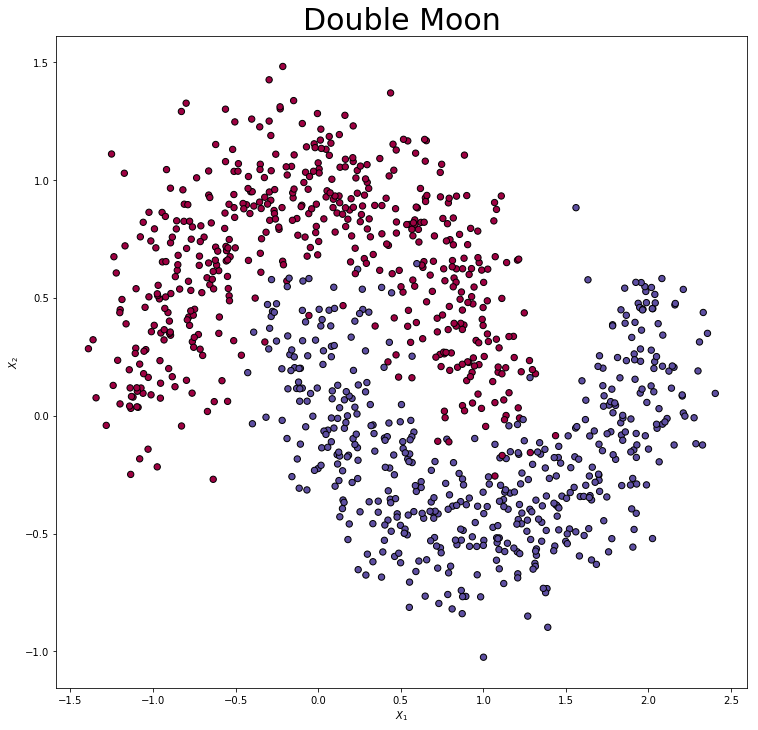

In [4]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

# Double moon dataset
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
        
make_plot(X, y, "Double Moon")

# Multi-layer Perceptron

1. Affine aka fully-connected layers
2. ReLU, Sigmoid activation functions
3. Backpropagation for the parameters update

## Layer initialization

In this function we initialize all trainable parameters of the MLP model.

`nn_architecture` is a list of dictionaries with layer specification.

`seed` defines the random seed for all initial parameters.

In [5]:
def init_layers(nn_architecture, seed = 42):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

## Activation functions

1. Sigmoid function -- we all know it already.

In [6]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

2. ReLU - Rectified Linear Unit. This is a piece-wise linear function. Got huge attention starting from legendary ImageNet 2012 paper.

In [7]:
def relu(Z):
    return np.maximum(0,Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

## Fully-connected layer execution

We have done this already for Logistic Regression lab and in Multiclass classfication lab.

## $$ Z_{l} = W_{l}A_{l-1} + b_{l} $$

`full_forward_propagation` defines the loop over layers with sequential execution, i.e. we go over DAG of computations.

In [8]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr


def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

## Cost computation

Our favorite LogReg loss! Nothing really new here.

## $$ L = -\frac{1}{m} (Y \log{\hat{Y}}^T + (1-Y)\log{(1 - \hat{Y})}^T) $$

In [39]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

##precision
def get_recall_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    i = 0
    for a in range (Y_hat.size):
        if Y_hat_[0][a] == 1 and Y[0][a] == 1:
            i+=1
    return i/(Y==1).all(axis=0).sum()

## Computing the gradients --- Backpropagation

In [10]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Making an update --- (Stochastic) Gradient Descend

In [11]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

## Training loop

In [12]:
def train(X, Y, nn_architecture, epochs, learning_rate, batch_size=128, verbose=False, callback=None, spam_ids=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    num_samples = X.shape[1]
    num_minibatches = int(X.shape[1] / batch_size)
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        for j in range(num_minibatches):
            # step forward
            inds = np.random.choice(X.shape[1], batch_size // 2)
            if spam_ids is not None:
                # oversampling minor class
                inds_spam = np.random.choice(spam_ids.shape[0], batch_size // 2)
                inds_spam = spam_ids[inds_spam]
                inds = np.concatenate((inds, inds_spam))
            Y_hat, cashe = full_forward_propagation(X[:,inds], params_values, nn_architecture)

            # step backward - calculating gradient
            grads_values = full_backward_propagation(Y_hat, Y[:, inds], cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if(i % 10 == 0):
            # calculating metrics and saving them in history
            cost = get_cost_value(Y_hat, Y[:,inds])
            accuracy = get_accuracy_value(Y_hat, Y[:, inds])
            cost_history.append(cost)
            accuracy_history.append(accuracy)

            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

# 1. Double moon classification

Firstly we define the architecture of our network

In [13]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [14]:
import ipdb
# Training
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 1000, 0.01, batch_size=64, verbose=True)

Iteration: 00000 - cost: 0.69146 - accuracy: 0.62500
Iteration: 00010 - cost: 0.69484 - accuracy: 0.40625
Iteration: 00020 - cost: 0.69571 - accuracy: 0.40625
Iteration: 00030 - cost: 0.68981 - accuracy: 0.62500
Iteration: 00040 - cost: 0.69295 - accuracy: 0.46875
Iteration: 00050 - cost: 0.69118 - accuracy: 0.53125
Iteration: 00060 - cost: 0.68947 - accuracy: 0.62500
Iteration: 00070 - cost: 0.69106 - accuracy: 0.50000
Iteration: 00080 - cost: 0.68762 - accuracy: 0.62500
Iteration: 00090 - cost: 0.69082 - accuracy: 0.43750
Iteration: 00100 - cost: 0.68871 - accuracy: 0.53125
Iteration: 00110 - cost: 0.68661 - accuracy: 0.71875
Iteration: 00120 - cost: 0.68731 - accuracy: 0.81250
Iteration: 00130 - cost: 0.68412 - accuracy: 0.93750
Iteration: 00140 - cost: 0.68094 - accuracy: 0.87500
Iteration: 00150 - cost: 0.67805 - accuracy: 0.78125
Iteration: 00160 - cost: 0.66369 - accuracy: 0.81250
Iteration: 00170 - cost: 0.64660 - accuracy: 0.90625
Iteration: 00180 - cost: 0.62356 - accuracy: 0

In [15]:
!pip install ipdb

## Some plots

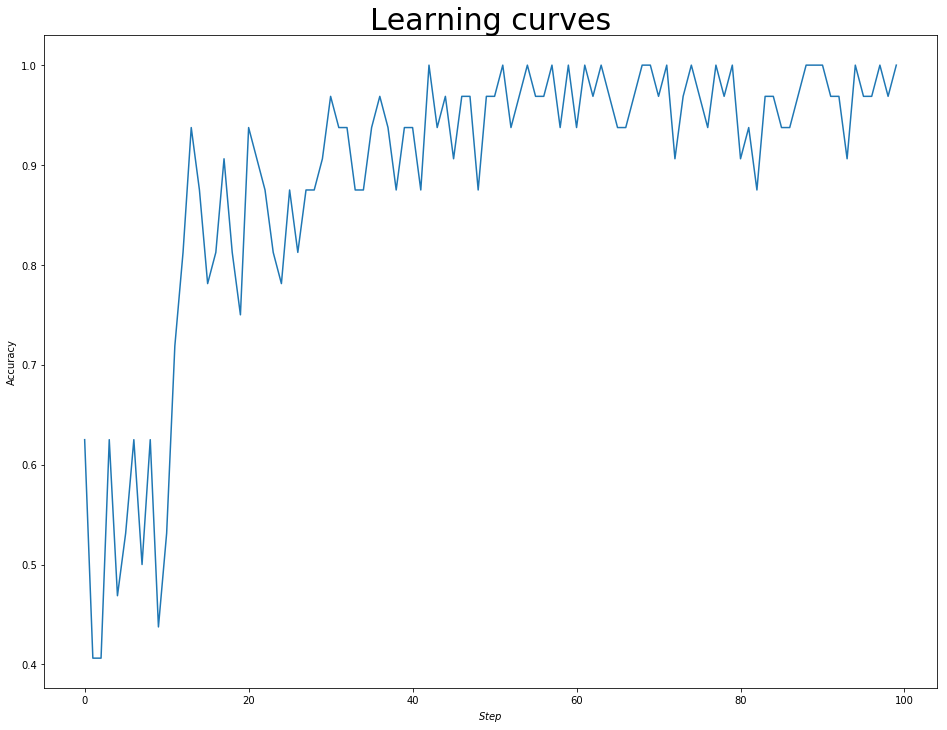

In [16]:
def simple_plot(metric, name):
    x_axis = np.arange(len(metric))
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Step$", ylabel=name)
    plt.title("Learning curves", fontsize=30)
    plt.plot(x_axis, np.array(ah))
    plt.show

simple_plot(ah, 'Accuracy')

In [17]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [18]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [19]:
acc_test

0.99

# Text classification

In [20]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# install nltk if needed
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
stemmer = SnowballStemmer("english")

## Text classification: variable length input!

In [21]:
# lets load some data first

spam_data = pickle.load(open('spam.pkl', 'rb'))
spam_data_input = [i[0] for i in spam_data]
cleaned_spam_data_input = []
one_line_data = []
for sent in spam_data_input:
    toked = word_tokenize(sent)
    stemmed = []
    for token in toked:
        stemmed.append(stemmer.stem(token))
    cleaned_spam_data_input.append(' '.join(stemmed))
    one_line_data.append(stemmed)
    

spam_data_label = [i[1] for i in spam_data]

_X_train, _X_test, _y_train, _y_test = train_test_split(cleaned_spam_data_input, spam_data_label)

## Lets check some examples

In [22]:
for i in range(10): print("{} - {}".format(_y_train[i], _X_train[i]))

1 - you have won a guarante £200 award or even £1000 cashto claim ur award call free on 08000407165 ( 18+ ) 2 stop getstop on 88222 php . rg21 4jx
0 - , how 's thing ? just a quick question .
0 - i 'm at home . pleas call
0 - good morn princess ! have a great day !
0 - whi did n't u call on your lunch ?
0 - finish alreadi ... yar they keep say i mushi ... i so embarrass ok ...
0 - greet me , ! consid yourself excus .
1 - 88066 from 88066 lost 3pound help
0 - to the wonder okor , have a great month . we cherish you guy and wish you well each day . mojibiola
0 - hi dear call me it urgnt . i do n't know what your problem . you do n't want to work or if you have ani other problem at least tell me . wate for your repli .


## Quick intro to Word2Vec

Relevant links:
https://radimrehurek.com/gensim/models/word2vec.html

original paper:
https://arxiv.org/pdf/1310.4546.pdf


In [23]:
import gensim 
from gensim.models import Word2Vec

vectors = Word2Vec(one_line_data, min_count=0)
vectors.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=10)
vecs = vectors.wv

## Lets check some word similarities

In [24]:
def get_word_similarity(s):
    print('sim({}) = {}'.format(s, vectors.similarity(s.split()[0], s.split()[1])))

## Task 1 Investigate different options to train Word2Vec model

## Option 1: number of epochs:
epochs = 10

In [24]:
get_word_similarity('dog urgnt')
get_word_similarity('great day')
get_word_similarity('award lunch')
get_word_similarity('quick help')

sim(dog urgnt) = 0.5655865669250488
sim(great day) = 0.9973838329315186
sim(award lunch) = 0.9753486514091492
sim(quick help) = 0.9965982437133789


C:\Users\kz882\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


epochs = 20

In [106]:
get_word_similarity('dog urgnt')
get_word_similarity('great day')
get_word_similarity('award lunch')
get_word_similarity('quick help')

sim(dog urgnt) = 0.8739098906517029
sim(great day) = 0.9980860948562622
sim(award lunch) = 0.9809961318969727
sim(quick help) = 0.9927999973297119


C:\Users\kz882\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


epochs = 30

In [109]:
get_word_similarity('dog urgnt')
get_word_similarity('great day')
get_word_similarity('award lunch')
get_word_similarity('quick help')

sim(dog urgnt) = 0.7398625612258911
sim(great day) = 0.9975398778915405
sim(award lunch) = 0.9685482382774353
sim(quick help) = 0.9986039996147156


C:\Users\kz882\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


## analysis:
sim3 means similarity when epochs is 30, similar with sim1 and sim2.<br>
sim(dog urgnt): sim1<sim3<sim2<br>
sim(great day): sim1<sim3<sim2<br>
sim(award lunch): sim3<sim1<sim2<br>
sim(quick help): sim2<sim1<sim3<br>
We can't really see a trend. <br>

We define the word pairs manually and have really small amount of training data here. Maybe the trend would be more obvious if we have bigger training data size.

## Option 2: min_count 
minimum frequency : when you train your word2vec you can specify different preprocessing e.g. min_count=N (that what is meant by min_frequency).  You can try any other arguments as well.<br>
min_count = 0

In [113]:
get_word_similarity('dog urgnt')
get_word_similarity('great day')
get_word_similarity('award lunch')
get_word_similarity('quick help')

sim(dog urgnt) = 0.9115014672279358
sim(great day) = 0.9972876906394958
sim(award lunch) = 0.9833239316940308
sim(quick help) = 0.9905246496200562


C:\Users\kz882\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


min_count = 1

In [115]:
get_word_similarity('dog urgnt')
get_word_similarity('great day')
get_word_similarity('award lunch')
get_word_similarity('quick help')

sim(dog urgnt) = 0.7138734459877014
sim(great day) = 0.9952739477157593
sim(award lunch) = 0.9786925911903381
sim(quick help) = 0.9972198605537415


C:\Users\kz882\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


min_count = 2

In [118]:
get_word_similarity('dog urgnt')
get_word_similarity('great day')
get_word_similarity('award lunch')
get_word_similarity('quick help')

sim(dog urgnt) = 0.9082421064376831
sim(great day) = 0.9984545707702637
sim(award lunch) = 0.9751296043395996
sim(quick help) = 0.9934662580490112


C:\Users\kz882\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


## analysis:
sim(dog urgnt) sim1<sim2<sim0 <br>
sim(great day) sim1<sim0<sim2 <br>
sim(award lunch) sim0<sim2<sim1 <br>
sim(quick help) sim0<sim2<sim1 <br>
I don't really see a trend when min_count changes. Similar as the above training option. We define the word pairs manually and have really small amount of training data here. Maybe the trend would be more obvious if we have bigger training data size.

In [25]:
WORD_EMB_DIM = 300
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 128, "activation": "sigmoid"},
    {"input_dim": 128, "output_dim": 128, "activation": "sigmoid"},
    {"input_dim": 128, "output_dim": 1, "activation": "sigmoid"},
]

## Convert text input data into the bag of words

Simply speaking, we take fixed dim embedding of every token in the sentence and average them all!

In [26]:
vector_based_spam_input = []
for sent in one_line_data:
    _tmp = []
    for w in sent:
        try:
            _tmp.append(vecs.get_vector(w))
        except:
            pass
    if len(_tmp) == 0:
        import ipdb; ipdb.set_trace()
    _avg = np.array(_tmp).mean(0)
    vector_based_spam_input.append(_avg)

In [27]:
print(cleaned_spam_data_input[3324])
print(vector_based_spam_input[3324])

she said , '' do u mind if i go into the bedroom for a minut ? `` 'ok '' , i sed in a sexi mood . she came out 5 minut latr wid a cake ... n my wife ,
[ 1.9393283e-01 -2.3110735e-01  1.4119616e-01 -4.5198396e-01
 -9.5575190e-01 -3.2624990e-01 -3.7832701e-01 -1.0111146e-01
  1.0201032e-02  4.7972709e-02  5.8873385e-01  5.0116551e-01
  4.9706396e-02 -2.7628520e-01 -7.3256600e-01 -8.3430046e-01
 -7.1743958e-02  8.3551562e-01 -7.9319680e-01  2.8253168e-01
 -7.2486508e-01  2.7102727e-01  6.6638418e-02  1.0155596e+00
  5.9044009e-01 -3.1233805e-01 -4.9406347e-01  1.0659614e+00
  3.5756999e-01 -3.9978859e-01 -4.6432209e-01 -8.1918789e-03
 -2.4425863e-01 -1.3465803e+00 -2.5659329e-01 -1.1912545e+00
  2.2068413e-01  6.8578726e-01 -5.5568135e-01  1.2506178e-01
  3.5429949e-01 -2.8896013e-01  3.9002660e-01  4.5117754e-01
 -6.2086749e-01  3.0570826e-01  3.6498111e-01 -4.2004609e-01
  9.4649315e-01  4.1614836e-01 -5.9767532e-01  1.7512278e-01
 -2.6979709e-01  2.8919289e-01  2.2745974e-01 -4.4673684

In [28]:
_X_train, _X_test, _y_train, _y_test = train_test_split(vector_based_spam_input, spam_data_label)

In [33]:
X_train = np.array(_X_train)
X_test = np.array(_X_test)
y_train = np.array(_y_train)
y_test = np.array(_y_test)

y_train_spam_ids = (y_train == 1).nonzero()[0]

In [34]:
WORD_EMB_DIM = X_train.shape[1]
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

## Task 2: Investigate different network architectures and hyper-parameters.
Below is the original training options unaltered from lab 03.

In [48]:
import ipdb
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.01, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69535 - accuracy: 0.41992
Iteration: 00010 - cost: 0.69056 - accuracy: 0.56055
Iteration: 00020 - cost: 0.68880 - accuracy: 0.56055
Iteration: 00030 - cost: 0.68855 - accuracy: 0.55273
Iteration: 00040 - cost: 0.68785 - accuracy: 0.55664
Iteration: 00050 - cost: 0.68412 - accuracy: 0.57227
Iteration: 00060 - cost: 0.68932 - accuracy: 0.54883
Iteration: 00070 - cost: 0.68411 - accuracy: 0.57031
Iteration: 00080 - cost: 0.68413 - accuracy: 0.57031
Iteration: 00090 - cost: 0.68303 - accuracy: 0.57422
Iteration: 00100 - cost: 0.68686 - accuracy: 0.55859
Iteration: 00110 - cost: 0.68809 - accuracy: 0.55469
Iteration: 00120 - cost: 0.68254 - accuracy: 0.57422
Iteration: 00130 - cost: 0.68380 - accuracy: 0.57031
Iteration: 00140 - cost: 0.68548 - accuracy: 0.56445
Iteration: 00150 - cost: 0.68874 - accuracy: 0.55078
Iteration: 00160 - cost: 0.68656 - accuracy: 0.55859
Iteration: 00170 - cost: 0.68402 - accuracy: 0.56836
Iteration: 00180 - cost: 0.67804 - accuracy: 0

Iteration: 01550 - cost: 0.61100 - accuracy: 0.73633
Iteration: 01560 - cost: 0.61669 - accuracy: 0.77344
Iteration: 01570 - cost: 0.61965 - accuracy: 0.73633
Iteration: 01580 - cost: 0.62042 - accuracy: 0.75586
Iteration: 01590 - cost: 0.60650 - accuracy: 0.75000
Iteration: 01600 - cost: 0.60407 - accuracy: 0.77539
Iteration: 01610 - cost: 0.61658 - accuracy: 0.76172
Iteration: 01620 - cost: 0.59089 - accuracy: 0.77734
Iteration: 01630 - cost: 0.58851 - accuracy: 0.79883
Iteration: 01640 - cost: 0.61046 - accuracy: 0.76758
Iteration: 01650 - cost: 0.59678 - accuracy: 0.77734
Iteration: 01660 - cost: 0.61310 - accuracy: 0.78320
Iteration: 01670 - cost: 0.62191 - accuracy: 0.75000
Iteration: 01680 - cost: 0.59129 - accuracy: 0.79297
Iteration: 01690 - cost: 0.58544 - accuracy: 0.79102
Iteration: 01700 - cost: 0.57583 - accuracy: 0.79688
Iteration: 01710 - cost: 0.59968 - accuracy: 0.78516
Iteration: 01720 - cost: 0.61075 - accuracy: 0.76562
Iteration: 01730 - cost: 0.57027 - accuracy: 0

Iteration: 03120 - cost: 0.46119 - accuracy: 0.81445
Iteration: 03130 - cost: 0.44467 - accuracy: 0.79297
Iteration: 03140 - cost: 0.47467 - accuracy: 0.80078
Iteration: 03150 - cost: 0.45859 - accuracy: 0.81641
Iteration: 03160 - cost: 0.44534 - accuracy: 0.80664
Iteration: 03170 - cost: 0.48549 - accuracy: 0.78711
Iteration: 03180 - cost: 0.48014 - accuracy: 0.76953
Iteration: 03190 - cost: 0.45343 - accuracy: 0.79688
Iteration: 03200 - cost: 0.42174 - accuracy: 0.83398
Iteration: 03210 - cost: 0.45776 - accuracy: 0.80273
Iteration: 03220 - cost: 0.47248 - accuracy: 0.78711
Iteration: 03230 - cost: 0.47592 - accuracy: 0.79102
Iteration: 03240 - cost: 0.45508 - accuracy: 0.79297
Iteration: 03250 - cost: 0.45458 - accuracy: 0.79102
Iteration: 03260 - cost: 0.45637 - accuracy: 0.78711
Iteration: 03270 - cost: 0.42341 - accuracy: 0.80859
Iteration: 03280 - cost: 0.41358 - accuracy: 0.82031
Iteration: 03290 - cost: 0.46405 - accuracy: 0.79688
Iteration: 03300 - cost: 0.46409 - accuracy: 0

Iteration: 04690 - cost: 0.41251 - accuracy: 0.83789
Iteration: 04700 - cost: 0.42123 - accuracy: 0.81836
Iteration: 04710 - cost: 0.38711 - accuracy: 0.84375
Iteration: 04720 - cost: 0.38558 - accuracy: 0.83203
Iteration: 04730 - cost: 0.35432 - accuracy: 0.86133
Iteration: 04740 - cost: 0.37152 - accuracy: 0.85938
Iteration: 04750 - cost: 0.41439 - accuracy: 0.83789
Iteration: 04760 - cost: 0.36758 - accuracy: 0.84961
Iteration: 04770 - cost: 0.38225 - accuracy: 0.84766
Iteration: 04780 - cost: 0.40331 - accuracy: 0.81641
Iteration: 04790 - cost: 0.35987 - accuracy: 0.85156
Iteration: 04800 - cost: 0.38499 - accuracy: 0.84961
Iteration: 04810 - cost: 0.42371 - accuracy: 0.83398
Iteration: 04820 - cost: 0.38325 - accuracy: 0.83789
Iteration: 04830 - cost: 0.39909 - accuracy: 0.83789
Iteration: 04840 - cost: 0.41629 - accuracy: 0.83203
Iteration: 04850 - cost: 0.38181 - accuracy: 0.84375
Iteration: 04860 - cost: 0.40447 - accuracy: 0.83789
Iteration: 04870 - cost: 0.38735 - accuracy: 0

Iteration: 06240 - cost: 0.36686 - accuracy: 0.84961
Iteration: 06250 - cost: 0.37888 - accuracy: 0.85352
Iteration: 06260 - cost: 0.39306 - accuracy: 0.84766
Iteration: 06270 - cost: 0.37690 - accuracy: 0.84961
Iteration: 06280 - cost: 0.36454 - accuracy: 0.85547
Iteration: 06290 - cost: 0.35917 - accuracy: 0.86719
Iteration: 06300 - cost: 0.35760 - accuracy: 0.86133
Iteration: 06310 - cost: 0.34653 - accuracy: 0.88477
Iteration: 06320 - cost: 0.37287 - accuracy: 0.83398
Iteration: 06330 - cost: 0.35893 - accuracy: 0.87305
Iteration: 06340 - cost: 0.38286 - accuracy: 0.85156
Iteration: 06350 - cost: 0.36058 - accuracy: 0.86914
Iteration: 06360 - cost: 0.36136 - accuracy: 0.83984
Iteration: 06370 - cost: 0.36334 - accuracy: 0.85156
Iteration: 06380 - cost: 0.39062 - accuracy: 0.83984
Iteration: 06390 - cost: 0.36494 - accuracy: 0.86133
Iteration: 06400 - cost: 0.38844 - accuracy: 0.85156
Iteration: 06410 - cost: 0.38692 - accuracy: 0.85156
Iteration: 06420 - cost: 0.41221 - accuracy: 0

Iteration: 07810 - cost: 0.31468 - accuracy: 0.88477
Iteration: 07820 - cost: 0.34308 - accuracy: 0.86914
Iteration: 07830 - cost: 0.33778 - accuracy: 0.87891
Iteration: 07840 - cost: 0.32293 - accuracy: 0.88867
Iteration: 07850 - cost: 0.38052 - accuracy: 0.83984
Iteration: 07860 - cost: 0.35701 - accuracy: 0.86914
Iteration: 07870 - cost: 0.33004 - accuracy: 0.87500
Iteration: 07880 - cost: 0.40662 - accuracy: 0.84961
Iteration: 07890 - cost: 0.30083 - accuracy: 0.89062
Iteration: 07900 - cost: 0.35180 - accuracy: 0.84766
Iteration: 07910 - cost: 0.40884 - accuracy: 0.84570
Iteration: 07920 - cost: 0.29507 - accuracy: 0.89258
Iteration: 07930 - cost: 0.37474 - accuracy: 0.84766
Iteration: 07940 - cost: 0.38894 - accuracy: 0.83398
Iteration: 07950 - cost: 0.35702 - accuracy: 0.84570
Iteration: 07960 - cost: 0.33643 - accuracy: 0.87695
Iteration: 07970 - cost: 0.36271 - accuracy: 0.84766
Iteration: 07980 - cost: 0.38545 - accuracy: 0.84766
Iteration: 07990 - cost: 0.38719 - accuracy: 0

Iteration: 09370 - cost: 0.33036 - accuracy: 0.86133
Iteration: 09380 - cost: 0.32742 - accuracy: 0.87500
Iteration: 09390 - cost: 0.31744 - accuracy: 0.87891
Iteration: 09400 - cost: 0.32352 - accuracy: 0.88086
Iteration: 09410 - cost: 0.36297 - accuracy: 0.86133
Iteration: 09420 - cost: 0.36491 - accuracy: 0.85547
Iteration: 09430 - cost: 0.31121 - accuracy: 0.87891
Iteration: 09440 - cost: 0.34186 - accuracy: 0.87305
Iteration: 09450 - cost: 0.34262 - accuracy: 0.85938
Iteration: 09460 - cost: 0.33100 - accuracy: 0.87695
Iteration: 09470 - cost: 0.31882 - accuracy: 0.87305
Iteration: 09480 - cost: 0.32459 - accuracy: 0.87891
Iteration: 09490 - cost: 0.32800 - accuracy: 0.86719
Iteration: 09500 - cost: 0.34730 - accuracy: 0.86133
Iteration: 09510 - cost: 0.35756 - accuracy: 0.86914
Iteration: 09520 - cost: 0.33198 - accuracy: 0.87500
Iteration: 09530 - cost: 0.29109 - accuracy: 0.88281
Iteration: 09540 - cost: 0.34792 - accuracy: 0.85742
Iteration: 09550 - cost: 0.33594 - accuracy: 0

## Some plots

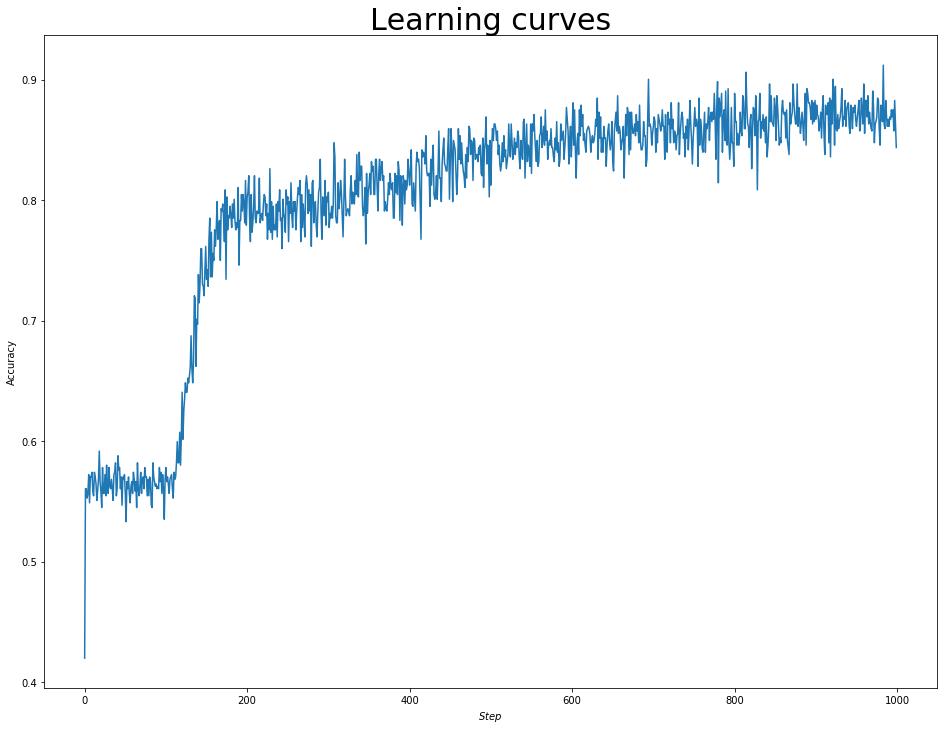

In [50]:
def simple_plot(metric, name):
    x_axis = np.arange(len(metric))
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Step$", ylabel=name)
    plt.title("Learning curves", fontsize=30)
    plt.plot(x_axis, np.array(ah))
    plt.show

simple_plot(ah, 'Accuracy')

In [51]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [52]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [53]:
acc_test

0.8106169296987088

In [54]:
rec_test

0.9104477611940298

## Option 1: number of epochs
change number of training epochs from 10000 to 20000. other stuff remains exactly the same.

In [55]:
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=20000, learning_rate=0.01, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69535 - accuracy: 0.41992
Iteration: 00010 - cost: 0.69056 - accuracy: 0.56055
Iteration: 00020 - cost: 0.68880 - accuracy: 0.56055
Iteration: 00030 - cost: 0.68855 - accuracy: 0.55273
Iteration: 00040 - cost: 0.68785 - accuracy: 0.55664
Iteration: 00050 - cost: 0.68412 - accuracy: 0.57227
Iteration: 00060 - cost: 0.68932 - accuracy: 0.54883
Iteration: 00070 - cost: 0.68411 - accuracy: 0.57031
Iteration: 00080 - cost: 0.68413 - accuracy: 0.57031
Iteration: 00090 - cost: 0.68303 - accuracy: 0.57422
Iteration: 00100 - cost: 0.68686 - accuracy: 0.55859
Iteration: 00110 - cost: 0.68809 - accuracy: 0.55469
Iteration: 00120 - cost: 0.68254 - accuracy: 0.57422
Iteration: 00130 - cost: 0.68380 - accuracy: 0.57031
Iteration: 00140 - cost: 0.68548 - accuracy: 0.56445
Iteration: 00150 - cost: 0.68874 - accuracy: 0.55078
Iteration: 00160 - cost: 0.68656 - accuracy: 0.55859
Iteration: 00170 - cost: 0.68402 - accuracy: 0.56836
Iteration: 00180 - cost: 0.67804 - accuracy: 0

Iteration: 01570 - cost: 0.61965 - accuracy: 0.73633
Iteration: 01580 - cost: 0.62042 - accuracy: 0.75586
Iteration: 01590 - cost: 0.60650 - accuracy: 0.75000
Iteration: 01600 - cost: 0.60407 - accuracy: 0.77539
Iteration: 01610 - cost: 0.61658 - accuracy: 0.76172
Iteration: 01620 - cost: 0.59089 - accuracy: 0.77734
Iteration: 01630 - cost: 0.58851 - accuracy: 0.79883
Iteration: 01640 - cost: 0.61046 - accuracy: 0.76758
Iteration: 01650 - cost: 0.59678 - accuracy: 0.77734
Iteration: 01660 - cost: 0.61310 - accuracy: 0.78320
Iteration: 01670 - cost: 0.62191 - accuracy: 0.75000
Iteration: 01680 - cost: 0.59129 - accuracy: 0.79297
Iteration: 01690 - cost: 0.58544 - accuracy: 0.79102
Iteration: 01700 - cost: 0.57583 - accuracy: 0.79688
Iteration: 01710 - cost: 0.59968 - accuracy: 0.78516
Iteration: 01720 - cost: 0.61075 - accuracy: 0.76562
Iteration: 01730 - cost: 0.57027 - accuracy: 0.80859
Iteration: 01740 - cost: 0.60712 - accuracy: 0.73438
Iteration: 01750 - cost: 0.57632 - accuracy: 0

Iteration: 03140 - cost: 0.47467 - accuracy: 0.80078
Iteration: 03150 - cost: 0.45859 - accuracy: 0.81641
Iteration: 03160 - cost: 0.44534 - accuracy: 0.80664
Iteration: 03170 - cost: 0.48549 - accuracy: 0.78711
Iteration: 03180 - cost: 0.48014 - accuracy: 0.76953
Iteration: 03190 - cost: 0.45343 - accuracy: 0.79688
Iteration: 03200 - cost: 0.42174 - accuracy: 0.83398
Iteration: 03210 - cost: 0.45776 - accuracy: 0.80273
Iteration: 03220 - cost: 0.47248 - accuracy: 0.78711
Iteration: 03230 - cost: 0.47592 - accuracy: 0.79102
Iteration: 03240 - cost: 0.45508 - accuracy: 0.79297
Iteration: 03250 - cost: 0.45458 - accuracy: 0.79102
Iteration: 03260 - cost: 0.45637 - accuracy: 0.78711
Iteration: 03270 - cost: 0.42341 - accuracy: 0.80859
Iteration: 03280 - cost: 0.41358 - accuracy: 0.82031
Iteration: 03290 - cost: 0.46405 - accuracy: 0.79688
Iteration: 03300 - cost: 0.46409 - accuracy: 0.80664
Iteration: 03310 - cost: 0.44037 - accuracy: 0.79883
Iteration: 03320 - cost: 0.45893 - accuracy: 0

Iteration: 04700 - cost: 0.42123 - accuracy: 0.81836
Iteration: 04710 - cost: 0.38711 - accuracy: 0.84375
Iteration: 04720 - cost: 0.38558 - accuracy: 0.83203
Iteration: 04730 - cost: 0.35432 - accuracy: 0.86133
Iteration: 04740 - cost: 0.37152 - accuracy: 0.85938
Iteration: 04750 - cost: 0.41439 - accuracy: 0.83789
Iteration: 04760 - cost: 0.36758 - accuracy: 0.84961
Iteration: 04770 - cost: 0.38225 - accuracy: 0.84766
Iteration: 04780 - cost: 0.40331 - accuracy: 0.81641
Iteration: 04790 - cost: 0.35987 - accuracy: 0.85156
Iteration: 04800 - cost: 0.38499 - accuracy: 0.84961
Iteration: 04810 - cost: 0.42371 - accuracy: 0.83398
Iteration: 04820 - cost: 0.38325 - accuracy: 0.83789
Iteration: 04830 - cost: 0.39909 - accuracy: 0.83789
Iteration: 04840 - cost: 0.41629 - accuracy: 0.83203
Iteration: 04850 - cost: 0.38181 - accuracy: 0.84375
Iteration: 04860 - cost: 0.40447 - accuracy: 0.83789
Iteration: 04870 - cost: 0.38735 - accuracy: 0.84570
Iteration: 04880 - cost: 0.42073 - accuracy: 0

Iteration: 06270 - cost: 0.37690 - accuracy: 0.84961
Iteration: 06280 - cost: 0.36454 - accuracy: 0.85547
Iteration: 06290 - cost: 0.35917 - accuracy: 0.86719
Iteration: 06300 - cost: 0.35760 - accuracy: 0.86133
Iteration: 06310 - cost: 0.34653 - accuracy: 0.88477
Iteration: 06320 - cost: 0.37287 - accuracy: 0.83398
Iteration: 06330 - cost: 0.35893 - accuracy: 0.87305
Iteration: 06340 - cost: 0.38286 - accuracy: 0.85156
Iteration: 06350 - cost: 0.36058 - accuracy: 0.86914
Iteration: 06360 - cost: 0.36136 - accuracy: 0.83984
Iteration: 06370 - cost: 0.36334 - accuracy: 0.85156
Iteration: 06380 - cost: 0.39062 - accuracy: 0.83984
Iteration: 06390 - cost: 0.36494 - accuracy: 0.86133
Iteration: 06400 - cost: 0.38844 - accuracy: 0.85156
Iteration: 06410 - cost: 0.38692 - accuracy: 0.85156
Iteration: 06420 - cost: 0.41221 - accuracy: 0.82812
Iteration: 06430 - cost: 0.38490 - accuracy: 0.84570
Iteration: 06440 - cost: 0.34475 - accuracy: 0.85742
Iteration: 06450 - cost: 0.36740 - accuracy: 0

Iteration: 07830 - cost: 0.33778 - accuracy: 0.87891
Iteration: 07840 - cost: 0.32293 - accuracy: 0.88867
Iteration: 07850 - cost: 0.38052 - accuracy: 0.83984
Iteration: 07860 - cost: 0.35701 - accuracy: 0.86914
Iteration: 07870 - cost: 0.33004 - accuracy: 0.87500
Iteration: 07880 - cost: 0.40662 - accuracy: 0.84961
Iteration: 07890 - cost: 0.30083 - accuracy: 0.89062
Iteration: 07900 - cost: 0.35180 - accuracy: 0.84766
Iteration: 07910 - cost: 0.40884 - accuracy: 0.84570
Iteration: 07920 - cost: 0.29507 - accuracy: 0.89258
Iteration: 07930 - cost: 0.37474 - accuracy: 0.84766
Iteration: 07940 - cost: 0.38894 - accuracy: 0.83398
Iteration: 07950 - cost: 0.35702 - accuracy: 0.84570
Iteration: 07960 - cost: 0.33643 - accuracy: 0.87695
Iteration: 07970 - cost: 0.36271 - accuracy: 0.84766
Iteration: 07980 - cost: 0.38545 - accuracy: 0.84766
Iteration: 07990 - cost: 0.38719 - accuracy: 0.82812
Iteration: 08000 - cost: 0.28806 - accuracy: 0.88867
Iteration: 08010 - cost: 0.34022 - accuracy: 0

Iteration: 09400 - cost: 0.32352 - accuracy: 0.88086
Iteration: 09410 - cost: 0.36297 - accuracy: 0.86133
Iteration: 09420 - cost: 0.36491 - accuracy: 0.85547
Iteration: 09430 - cost: 0.31121 - accuracy: 0.87891
Iteration: 09440 - cost: 0.34186 - accuracy: 0.87305
Iteration: 09450 - cost: 0.34262 - accuracy: 0.85938
Iteration: 09460 - cost: 0.33100 - accuracy: 0.87695
Iteration: 09470 - cost: 0.31882 - accuracy: 0.87305
Iteration: 09480 - cost: 0.32459 - accuracy: 0.87891
Iteration: 09490 - cost: 0.32800 - accuracy: 0.86719
Iteration: 09500 - cost: 0.34730 - accuracy: 0.86133
Iteration: 09510 - cost: 0.35756 - accuracy: 0.86914
Iteration: 09520 - cost: 0.33198 - accuracy: 0.87500
Iteration: 09530 - cost: 0.29109 - accuracy: 0.88281
Iteration: 09540 - cost: 0.34792 - accuracy: 0.85742
Iteration: 09550 - cost: 0.33594 - accuracy: 0.86328
Iteration: 09560 - cost: 0.31105 - accuracy: 0.88477
Iteration: 09570 - cost: 0.31200 - accuracy: 0.87500
Iteration: 09580 - cost: 0.33909 - accuracy: 0

Iteration: 10960 - cost: 0.30364 - accuracy: 0.87109
Iteration: 10970 - cost: 0.33893 - accuracy: 0.86719
Iteration: 10980 - cost: 0.34653 - accuracy: 0.86328
Iteration: 10990 - cost: 0.32808 - accuracy: 0.88477
Iteration: 11000 - cost: 0.29416 - accuracy: 0.88477
Iteration: 11010 - cost: 0.31751 - accuracy: 0.86328
Iteration: 11020 - cost: 0.31007 - accuracy: 0.88867
Iteration: 11030 - cost: 0.33342 - accuracy: 0.87305
Iteration: 11040 - cost: 0.29068 - accuracy: 0.90234
Iteration: 11050 - cost: 0.33058 - accuracy: 0.88672
Iteration: 11060 - cost: 0.30419 - accuracy: 0.88281
Iteration: 11070 - cost: 0.34915 - accuracy: 0.85547
Iteration: 11080 - cost: 0.30500 - accuracy: 0.87891
Iteration: 11090 - cost: 0.29432 - accuracy: 0.87695
Iteration: 11100 - cost: 0.31702 - accuracy: 0.89062
Iteration: 11110 - cost: 0.32814 - accuracy: 0.87109
Iteration: 11120 - cost: 0.36932 - accuracy: 0.86133
Iteration: 11130 - cost: 0.34408 - accuracy: 0.86914
Iteration: 11140 - cost: 0.41024 - accuracy: 0

Iteration: 12550 - cost: 0.28189 - accuracy: 0.87695
Iteration: 12560 - cost: 0.32686 - accuracy: 0.88672
Iteration: 12570 - cost: 0.32459 - accuracy: 0.86719
Iteration: 12580 - cost: 0.33567 - accuracy: 0.86523
Iteration: 12590 - cost: 0.31861 - accuracy: 0.88867
Iteration: 12600 - cost: 0.35172 - accuracy: 0.86133
Iteration: 12610 - cost: 0.26827 - accuracy: 0.90430
Iteration: 12620 - cost: 0.31576 - accuracy: 0.86328
Iteration: 12630 - cost: 0.32107 - accuracy: 0.86133
Iteration: 12640 - cost: 0.28586 - accuracy: 0.89062
Iteration: 12650 - cost: 0.31656 - accuracy: 0.87695
Iteration: 12660 - cost: 0.25713 - accuracy: 0.90820
Iteration: 12670 - cost: 0.35055 - accuracy: 0.86133
Iteration: 12680 - cost: 0.32163 - accuracy: 0.87109
Iteration: 12690 - cost: 0.30700 - accuracy: 0.87109
Iteration: 12700 - cost: 0.35870 - accuracy: 0.84375
Iteration: 12710 - cost: 0.34163 - accuracy: 0.85742
Iteration: 12720 - cost: 0.29189 - accuracy: 0.88281
Iteration: 12730 - cost: 0.30924 - accuracy: 0

Iteration: 14110 - cost: 0.29618 - accuracy: 0.87891
Iteration: 14120 - cost: 0.30392 - accuracy: 0.88867
Iteration: 14130 - cost: 0.28837 - accuracy: 0.88281
Iteration: 14140 - cost: 0.30981 - accuracy: 0.87109
Iteration: 14150 - cost: 0.30268 - accuracy: 0.87500
Iteration: 14160 - cost: 0.28021 - accuracy: 0.89648
Iteration: 14170 - cost: 0.28039 - accuracy: 0.91406
Iteration: 14180 - cost: 0.30119 - accuracy: 0.88086
Iteration: 14190 - cost: 0.28063 - accuracy: 0.89453
Iteration: 14200 - cost: 0.32721 - accuracy: 0.88086
Iteration: 14210 - cost: 0.27889 - accuracy: 0.90039
Iteration: 14220 - cost: 0.31501 - accuracy: 0.87891
Iteration: 14230 - cost: 0.30299 - accuracy: 0.88086
Iteration: 14240 - cost: 0.31294 - accuracy: 0.86523
Iteration: 14250 - cost: 0.31167 - accuracy: 0.88672
Iteration: 14260 - cost: 0.30588 - accuracy: 0.88672
Iteration: 14270 - cost: 0.29895 - accuracy: 0.87695
Iteration: 14280 - cost: 0.37909 - accuracy: 0.86523
Iteration: 14290 - cost: 0.32879 - accuracy: 0

Iteration: 15660 - cost: 0.28639 - accuracy: 0.89062
Iteration: 15670 - cost: 0.31656 - accuracy: 0.89258
Iteration: 15680 - cost: 0.32222 - accuracy: 0.87305
Iteration: 15690 - cost: 0.30461 - accuracy: 0.87891
Iteration: 15700 - cost: 0.27347 - accuracy: 0.89062
Iteration: 15710 - cost: 0.27987 - accuracy: 0.88672
Iteration: 15720 - cost: 0.30624 - accuracy: 0.88281
Iteration: 15730 - cost: 0.29525 - accuracy: 0.89258
Iteration: 15740 - cost: 0.29570 - accuracy: 0.87305
Iteration: 15750 - cost: 0.31918 - accuracy: 0.87305
Iteration: 15760 - cost: 0.29305 - accuracy: 0.88477
Iteration: 15770 - cost: 0.28165 - accuracy: 0.90234
Iteration: 15780 - cost: 0.28677 - accuracy: 0.88867
Iteration: 15790 - cost: 0.33904 - accuracy: 0.86719
Iteration: 15800 - cost: 0.29407 - accuracy: 0.88281
Iteration: 15810 - cost: 0.31736 - accuracy: 0.88281
Iteration: 15820 - cost: 0.27962 - accuracy: 0.89648
Iteration: 15830 - cost: 0.25328 - accuracy: 0.90234
Iteration: 15840 - cost: 0.29791 - accuracy: 0

Iteration: 17220 - cost: 0.26388 - accuracy: 0.91211
Iteration: 17230 - cost: 0.28398 - accuracy: 0.89258
Iteration: 17240 - cost: 0.30621 - accuracy: 0.88672
Iteration: 17250 - cost: 0.23887 - accuracy: 0.92188
Iteration: 17260 - cost: 0.26970 - accuracy: 0.88867
Iteration: 17270 - cost: 0.28815 - accuracy: 0.89648
Iteration: 17280 - cost: 0.27399 - accuracy: 0.90039
Iteration: 17290 - cost: 0.30276 - accuracy: 0.89844
Iteration: 17300 - cost: 0.26472 - accuracy: 0.88672
Iteration: 17310 - cost: 0.31351 - accuracy: 0.88672
Iteration: 17320 - cost: 0.26239 - accuracy: 0.90234
Iteration: 17330 - cost: 0.28959 - accuracy: 0.89648
Iteration: 17340 - cost: 0.23722 - accuracy: 0.91992
Iteration: 17350 - cost: 0.29524 - accuracy: 0.88281
Iteration: 17360 - cost: 0.36808 - accuracy: 0.84766
Iteration: 17370 - cost: 0.29671 - accuracy: 0.89062
Iteration: 17380 - cost: 0.30582 - accuracy: 0.88867
Iteration: 17390 - cost: 0.29027 - accuracy: 0.89062
Iteration: 17400 - cost: 0.24722 - accuracy: 0

Iteration: 18800 - cost: 0.25950 - accuracy: 0.90430
Iteration: 18810 - cost: 0.26770 - accuracy: 0.89648
Iteration: 18820 - cost: 0.30768 - accuracy: 0.87500
Iteration: 18830 - cost: 0.25201 - accuracy: 0.90820
Iteration: 18840 - cost: 0.27079 - accuracy: 0.90039
Iteration: 18850 - cost: 0.28088 - accuracy: 0.89258
Iteration: 18860 - cost: 0.28375 - accuracy: 0.90039
Iteration: 18870 - cost: 0.29413 - accuracy: 0.89062
Iteration: 18880 - cost: 0.30404 - accuracy: 0.87891
Iteration: 18890 - cost: 0.28230 - accuracy: 0.90039
Iteration: 18900 - cost: 0.27644 - accuracy: 0.89844
Iteration: 18910 - cost: 0.33663 - accuracy: 0.89062
Iteration: 18920 - cost: 0.26704 - accuracy: 0.89844
Iteration: 18930 - cost: 0.28998 - accuracy: 0.87695
Iteration: 18940 - cost: 0.29764 - accuracy: 0.87500
Iteration: 18950 - cost: 0.26994 - accuracy: 0.90820
Iteration: 18960 - cost: 0.28075 - accuracy: 0.88867
Iteration: 18970 - cost: 0.29952 - accuracy: 0.88086
Iteration: 18980 - cost: 0.33978 - accuracy: 0

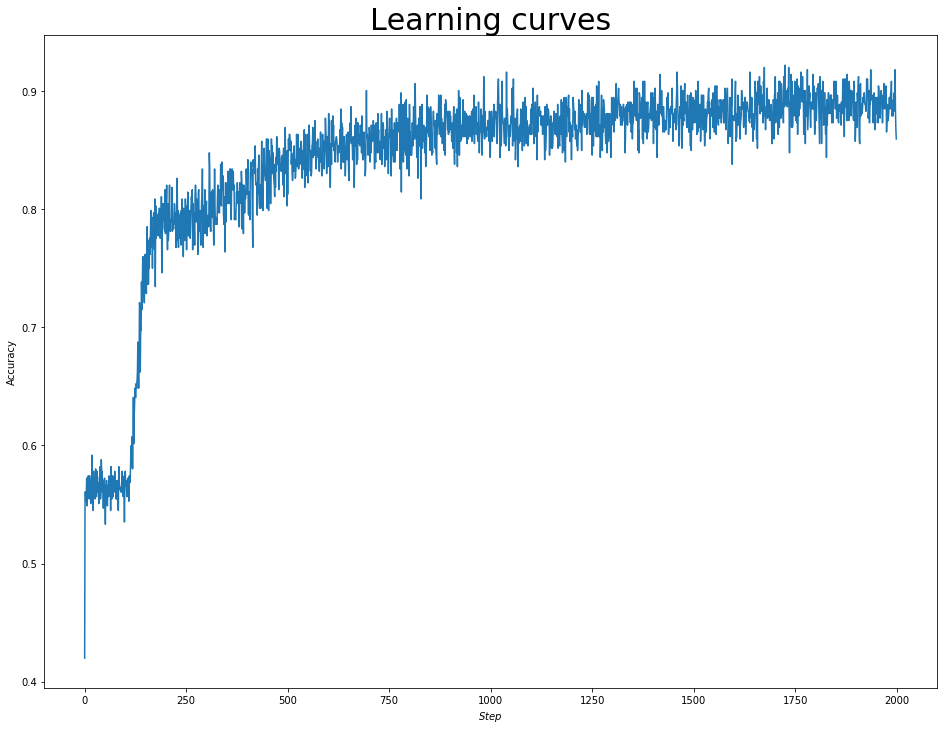

In [56]:
simple_plot(ah, 'Accuracy')

In [57]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [58]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [59]:
acc_test

0.8486370157819225

In [60]:
rec_test

0.9154228855721394

## analysis:
epochs = 10000, acc_test = 0.8106169296987088, rec_test = 0.9104477611940298 <br>
epochs = 20000, acc_test = 0.8486370157819225, rec_test = 0.9154228855721394 <br>
As there are more epochs, accuracy of test samples becomes higher. We can also see the trend just by looking at the learning curve. As there are more epoches, the accuracy tends to oscillate but grows higher in general.

## Option 2: learning rate
part 1: change learning rate from 0.01 to 0.001. other stuff remains exactly the same.

In [61]:
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.001, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69587 - accuracy: 0.42383
Iteration: 00010 - cost: 0.69535 - accuracy: 0.41602
Iteration: 00020 - cost: 0.69526 - accuracy: 0.40039
Iteration: 00030 - cost: 0.69387 - accuracy: 0.41211
Iteration: 00040 - cost: 0.69374 - accuracy: 0.56836
Iteration: 00050 - cost: 0.69273 - accuracy: 0.57812
Iteration: 00060 - cost: 0.69278 - accuracy: 0.54883
Iteration: 00070 - cost: 0.69148 - accuracy: 0.57031
Iteration: 00080 - cost: 0.69118 - accuracy: 0.57031
Iteration: 00090 - cost: 0.69052 - accuracy: 0.57422
Iteration: 00100 - cost: 0.69104 - accuracy: 0.55859
Iteration: 00110 - cost: 0.69144 - accuracy: 0.55469
Iteration: 00120 - cost: 0.68881 - accuracy: 0.57422
Iteration: 00130 - cost: 0.68934 - accuracy: 0.57031
Iteration: 00140 - cost: 0.68979 - accuracy: 0.56445
Iteration: 00150 - cost: 0.69059 - accuracy: 0.55078
Iteration: 00160 - cost: 0.68961 - accuracy: 0.55859
Iteration: 00170 - cost: 0.68830 - accuracy: 0.56836
Iteration: 00180 - cost: 0.68557 - accuracy: 0

Iteration: 01570 - cost: 0.68664 - accuracy: 0.55859
Iteration: 01580 - cost: 0.68576 - accuracy: 0.56250
Iteration: 01590 - cost: 0.68351 - accuracy: 0.57031
Iteration: 01600 - cost: 0.68493 - accuracy: 0.56445
Iteration: 01610 - cost: 0.68403 - accuracy: 0.56836
Iteration: 01620 - cost: 0.68130 - accuracy: 0.57812
Iteration: 01630 - cost: 0.68298 - accuracy: 0.57227
Iteration: 01640 - cost: 0.68567 - accuracy: 0.56250
Iteration: 01650 - cost: 0.68652 - accuracy: 0.55859
Iteration: 01660 - cost: 0.68650 - accuracy: 0.55859
Iteration: 01670 - cost: 0.68525 - accuracy: 0.56445
Iteration: 01680 - cost: 0.68763 - accuracy: 0.55469
Iteration: 01690 - cost: 0.68552 - accuracy: 0.56250
Iteration: 01700 - cost: 0.68288 - accuracy: 0.57227
Iteration: 01710 - cost: 0.68408 - accuracy: 0.56836
Iteration: 01720 - cost: 0.68301 - accuracy: 0.57227
Iteration: 01730 - cost: 0.68910 - accuracy: 0.54883
Iteration: 01740 - cost: 0.68244 - accuracy: 0.57422
Iteration: 01750 - cost: 0.68096 - accuracy: 0

Iteration: 03140 - cost: 0.68796 - accuracy: 0.55078
Iteration: 03150 - cost: 0.68419 - accuracy: 0.56445
Iteration: 03160 - cost: 0.68235 - accuracy: 0.57227
Iteration: 03170 - cost: 0.68346 - accuracy: 0.56836
Iteration: 03180 - cost: 0.68015 - accuracy: 0.58008
Iteration: 03190 - cost: 0.68553 - accuracy: 0.56055
Iteration: 03200 - cost: 0.68270 - accuracy: 0.57031
Iteration: 03210 - cost: 0.68283 - accuracy: 0.57031
Iteration: 03220 - cost: 0.68327 - accuracy: 0.56836
Iteration: 03230 - cost: 0.68850 - accuracy: 0.54883
Iteration: 03240 - cost: 0.68223 - accuracy: 0.57227
Iteration: 03250 - cost: 0.68516 - accuracy: 0.56055
Iteration: 03260 - cost: 0.68239 - accuracy: 0.57227
Iteration: 03270 - cost: 0.68271 - accuracy: 0.57031
Iteration: 03280 - cost: 0.68356 - accuracy: 0.56641
Iteration: 03290 - cost: 0.68855 - accuracy: 0.54883
Iteration: 03300 - cost: 0.68873 - accuracy: 0.54688
Iteration: 03310 - cost: 0.68497 - accuracy: 0.56250
Iteration: 03320 - cost: 0.67874 - accuracy: 0

Iteration: 04720 - cost: 0.68392 - accuracy: 0.56055
Iteration: 04730 - cost: 0.68371 - accuracy: 0.56055
Iteration: 04740 - cost: 0.67886 - accuracy: 0.57812
Iteration: 04750 - cost: 0.68556 - accuracy: 0.55469
Iteration: 04760 - cost: 0.68225 - accuracy: 0.56641
Iteration: 04770 - cost: 0.67880 - accuracy: 0.58008
Iteration: 04780 - cost: 0.68685 - accuracy: 0.55078
Iteration: 04790 - cost: 0.68263 - accuracy: 0.56445
Iteration: 04800 - cost: 0.68419 - accuracy: 0.55859
Iteration: 04810 - cost: 0.68319 - accuracy: 0.56445
Iteration: 04820 - cost: 0.67969 - accuracy: 0.57617
Iteration: 04830 - cost: 0.68568 - accuracy: 0.55273
Iteration: 04840 - cost: 0.68918 - accuracy: 0.54102
Iteration: 04850 - cost: 0.68340 - accuracy: 0.56055
Iteration: 04860 - cost: 0.68186 - accuracy: 0.56641
Iteration: 04870 - cost: 0.68128 - accuracy: 0.57031
Iteration: 04880 - cost: 0.68264 - accuracy: 0.56445
Iteration: 04890 - cost: 0.67640 - accuracy: 0.58984
Iteration: 04900 - cost: 0.68412 - accuracy: 0

Iteration: 06290 - cost: 0.68045 - accuracy: 0.56641
Iteration: 06300 - cost: 0.67735 - accuracy: 0.57227
Iteration: 06310 - cost: 0.67316 - accuracy: 0.59180
Iteration: 06320 - cost: 0.67651 - accuracy: 0.58008
Iteration: 06330 - cost: 0.68009 - accuracy: 0.56641
Iteration: 06340 - cost: 0.68085 - accuracy: 0.56250
Iteration: 06350 - cost: 0.67796 - accuracy: 0.57227
Iteration: 06360 - cost: 0.67613 - accuracy: 0.58008
Iteration: 06370 - cost: 0.67595 - accuracy: 0.58203
Iteration: 06380 - cost: 0.68422 - accuracy: 0.54883
Iteration: 06390 - cost: 0.67877 - accuracy: 0.56836
Iteration: 06400 - cost: 0.67576 - accuracy: 0.58203
Iteration: 06410 - cost: 0.68101 - accuracy: 0.56641
Iteration: 06420 - cost: 0.68133 - accuracy: 0.56055
Iteration: 06430 - cost: 0.68026 - accuracy: 0.56250
Iteration: 06440 - cost: 0.67494 - accuracy: 0.58398
Iteration: 06450 - cost: 0.68040 - accuracy: 0.56445
Iteration: 06460 - cost: 0.68281 - accuracy: 0.55664
Iteration: 06470 - cost: 0.68557 - accuracy: 0

Iteration: 07860 - cost: 0.67569 - accuracy: 0.56641
Iteration: 07870 - cost: 0.67742 - accuracy: 0.55273
Iteration: 07880 - cost: 0.67968 - accuracy: 0.54688
Iteration: 07890 - cost: 0.67536 - accuracy: 0.56445
Iteration: 07900 - cost: 0.67483 - accuracy: 0.56445
Iteration: 07910 - cost: 0.67720 - accuracy: 0.56250
Iteration: 07920 - cost: 0.67968 - accuracy: 0.54492
Iteration: 07930 - cost: 0.67392 - accuracy: 0.57422
Iteration: 07940 - cost: 0.67626 - accuracy: 0.56445
Iteration: 07950 - cost: 0.67472 - accuracy: 0.57227
Iteration: 07960 - cost: 0.67830 - accuracy: 0.55469
Iteration: 07970 - cost: 0.67738 - accuracy: 0.55859
Iteration: 07980 - cost: 0.68221 - accuracy: 0.54102
Iteration: 07990 - cost: 0.67559 - accuracy: 0.56250
Iteration: 08000 - cost: 0.67048 - accuracy: 0.57617
Iteration: 08010 - cost: 0.67249 - accuracy: 0.57227
Iteration: 08020 - cost: 0.66659 - accuracy: 0.59570
Iteration: 08030 - cost: 0.67641 - accuracy: 0.55859
Iteration: 08040 - cost: 0.67558 - accuracy: 0

Iteration: 09410 - cost: 0.66614 - accuracy: 0.58789
Iteration: 09420 - cost: 0.66817 - accuracy: 0.57227
Iteration: 09430 - cost: 0.66422 - accuracy: 0.58594
Iteration: 09440 - cost: 0.66722 - accuracy: 0.55859
Iteration: 09450 - cost: 0.67246 - accuracy: 0.55078
Iteration: 09460 - cost: 0.66909 - accuracy: 0.56250
Iteration: 09470 - cost: 0.67072 - accuracy: 0.55469
Iteration: 09480 - cost: 0.67045 - accuracy: 0.56250
Iteration: 09490 - cost: 0.67403 - accuracy: 0.55078
Iteration: 09500 - cost: 0.67056 - accuracy: 0.56641
Iteration: 09510 - cost: 0.66518 - accuracy: 0.57812
Iteration: 09520 - cost: 0.66717 - accuracy: 0.56836
Iteration: 09530 - cost: 0.66566 - accuracy: 0.57422
Iteration: 09540 - cost: 0.66898 - accuracy: 0.56641
Iteration: 09550 - cost: 0.67237 - accuracy: 0.55078
Iteration: 09560 - cost: 0.66748 - accuracy: 0.57812
Iteration: 09570 - cost: 0.66806 - accuracy: 0.56836
Iteration: 09580 - cost: 0.66567 - accuracy: 0.56055
Iteration: 09590 - cost: 0.66480 - accuracy: 0

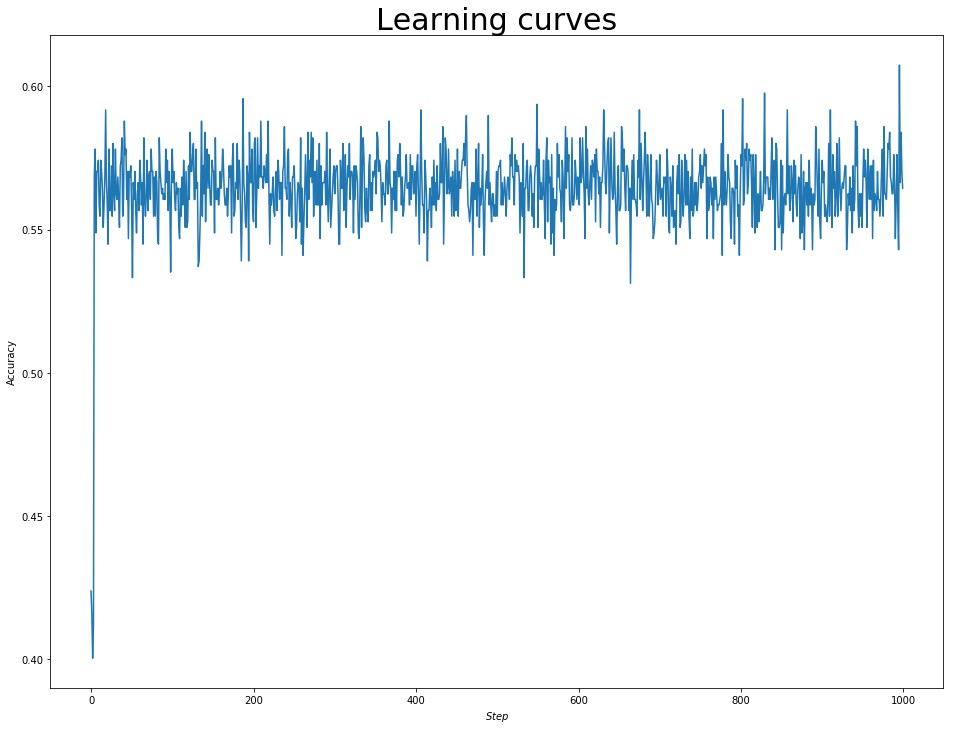

In [62]:
simple_plot(ah, 'Accuracy')

In [63]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [64]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [65]:
acc_test

0.14562410329985653

In [66]:
rec_test

1.0

part 2: change learning rate from 0.01 to 0.1. other stuff remains exactly the same.

In [67]:
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.1, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69177 - accuracy: 0.54883
Iteration: 00010 - cost: 0.68631 - accuracy: 0.56055
Iteration: 00020 - cost: 0.68622 - accuracy: 0.56055
Iteration: 00030 - cost: 0.68733 - accuracy: 0.55273
Iteration: 00040 - cost: 0.68588 - accuracy: 0.55664
Iteration: 00050 - cost: 0.68051 - accuracy: 0.57227
Iteration: 00060 - cost: 0.68426 - accuracy: 0.54883
Iteration: 00070 - cost: 0.67697 - accuracy: 0.57031
Iteration: 00080 - cost: 0.67142 - accuracy: 0.57031
Iteration: 00090 - cost: 0.66930 - accuracy: 0.57422
Iteration: 00100 - cost: 0.66522 - accuracy: 0.55859
Iteration: 00110 - cost: 0.66024 - accuracy: 0.56836
Iteration: 00120 - cost: 0.65258 - accuracy: 0.62305
Iteration: 00130 - cost: 0.63363 - accuracy: 0.70508
Iteration: 00140 - cost: 0.64092 - accuracy: 0.73242
Iteration: 00150 - cost: 0.61349 - accuracy: 0.74609
Iteration: 00160 - cost: 0.59764 - accuracy: 0.78711
Iteration: 00170 - cost: 0.59196 - accuracy: 0.79297
Iteration: 00180 - cost: 0.56577 - accuracy: 0

Iteration: 01580 - cost: 0.28959 - accuracy: 0.90039
Iteration: 01590 - cost: 0.32086 - accuracy: 0.87891
Iteration: 01600 - cost: 0.29710 - accuracy: 0.89062
Iteration: 01610 - cost: 0.29984 - accuracy: 0.89062
Iteration: 01620 - cost: 0.30215 - accuracy: 0.87305
Iteration: 01630 - cost: 0.29026 - accuracy: 0.88477
Iteration: 01640 - cost: 0.33381 - accuracy: 0.86328
Iteration: 01650 - cost: 0.26507 - accuracy: 0.89258
Iteration: 01660 - cost: 0.33457 - accuracy: 0.87109
Iteration: 01670 - cost: 0.33941 - accuracy: 0.86328
Iteration: 01680 - cost: 0.27378 - accuracy: 0.90625
Iteration: 01690 - cost: 0.29968 - accuracy: 0.90039
Iteration: 01700 - cost: 0.32051 - accuracy: 0.86914
Iteration: 01710 - cost: 0.26672 - accuracy: 0.90820
Iteration: 01720 - cost: 0.30472 - accuracy: 0.88867
Iteration: 01730 - cost: 0.27963 - accuracy: 0.89453
Iteration: 01740 - cost: 0.35626 - accuracy: 0.84961
Iteration: 01750 - cost: 0.27590 - accuracy: 0.89062
Iteration: 01760 - cost: 0.29644 - accuracy: 0

Iteration: 03160 - cost: 0.25548 - accuracy: 0.89453
Iteration: 03170 - cost: 0.31561 - accuracy: 0.88281
Iteration: 03180 - cost: 0.29997 - accuracy: 0.88672
Iteration: 03190 - cost: 0.25493 - accuracy: 0.90820
Iteration: 03200 - cost: 0.26120 - accuracy: 0.91211
Iteration: 03210 - cost: 0.23131 - accuracy: 0.90625
Iteration: 03220 - cost: 0.24368 - accuracy: 0.89453
Iteration: 03230 - cost: 0.24699 - accuracy: 0.91016
Iteration: 03240 - cost: 0.28980 - accuracy: 0.87695
Iteration: 03250 - cost: 0.27336 - accuracy: 0.89062
Iteration: 03260 - cost: 0.26233 - accuracy: 0.89453
Iteration: 03270 - cost: 0.22087 - accuracy: 0.91406
Iteration: 03280 - cost: 0.25725 - accuracy: 0.89648
Iteration: 03290 - cost: 0.26137 - accuracy: 0.91992
Iteration: 03300 - cost: 0.30553 - accuracy: 0.90039
Iteration: 03310 - cost: 0.27111 - accuracy: 0.89844
Iteration: 03320 - cost: 0.29928 - accuracy: 0.88281
Iteration: 03330 - cost: 0.25803 - accuracy: 0.90820
Iteration: 03340 - cost: 0.27943 - accuracy: 0

Iteration: 04730 - cost: 0.21479 - accuracy: 0.92383
Iteration: 04740 - cost: 0.23386 - accuracy: 0.90234
Iteration: 04750 - cost: 0.24248 - accuracy: 0.91406
Iteration: 04760 - cost: 0.21530 - accuracy: 0.93359
Iteration: 04770 - cost: 0.22767 - accuracy: 0.90625
Iteration: 04780 - cost: 0.25064 - accuracy: 0.91016
Iteration: 04790 - cost: 0.21219 - accuracy: 0.92969
Iteration: 04800 - cost: 0.27101 - accuracy: 0.90234
Iteration: 04810 - cost: 0.28643 - accuracy: 0.88672
Iteration: 04820 - cost: 0.24063 - accuracy: 0.91016
Iteration: 04830 - cost: 0.28532 - accuracy: 0.88867
Iteration: 04840 - cost: 0.26556 - accuracy: 0.88867
Iteration: 04850 - cost: 0.23608 - accuracy: 0.92188
Iteration: 04860 - cost: 0.26531 - accuracy: 0.90039
Iteration: 04870 - cost: 0.25038 - accuracy: 0.90430
Iteration: 04880 - cost: 0.26534 - accuracy: 0.89648
Iteration: 04890 - cost: 0.28104 - accuracy: 0.89258
Iteration: 04900 - cost: 0.23045 - accuracy: 0.91602
Iteration: 04910 - cost: 0.25603 - accuracy: 0

Iteration: 06300 - cost: 0.22863 - accuracy: 0.90625
Iteration: 06310 - cost: 0.19037 - accuracy: 0.92969
Iteration: 06320 - cost: 0.23027 - accuracy: 0.90625
Iteration: 06330 - cost: 0.18846 - accuracy: 0.92773
Iteration: 06340 - cost: 0.23117 - accuracy: 0.90039
Iteration: 06350 - cost: 0.24177 - accuracy: 0.90039
Iteration: 06360 - cost: 0.23281 - accuracy: 0.91797
Iteration: 06370 - cost: 0.21020 - accuracy: 0.91797
Iteration: 06380 - cost: 0.24312 - accuracy: 0.89453
Iteration: 06390 - cost: 0.21449 - accuracy: 0.92188
Iteration: 06400 - cost: 0.23795 - accuracy: 0.89844
Iteration: 06410 - cost: 0.23408 - accuracy: 0.91211
Iteration: 06420 - cost: 0.28915 - accuracy: 0.87305
Iteration: 06430 - cost: 0.24623 - accuracy: 0.90039
Iteration: 06440 - cost: 0.21539 - accuracy: 0.92188
Iteration: 06450 - cost: 0.23217 - accuracy: 0.89844
Iteration: 06460 - cost: 0.21046 - accuracy: 0.92969
Iteration: 06470 - cost: 0.25279 - accuracy: 0.90430
Iteration: 06480 - cost: 0.22483 - accuracy: 0

Iteration: 07850 - cost: 0.24949 - accuracy: 0.90625
Iteration: 07860 - cost: 0.21910 - accuracy: 0.90430
Iteration: 07870 - cost: 0.20744 - accuracy: 0.91211
Iteration: 07880 - cost: 0.25558 - accuracy: 0.89062
Iteration: 07890 - cost: 0.21139 - accuracy: 0.91797
Iteration: 07900 - cost: 0.23455 - accuracy: 0.90820
Iteration: 07910 - cost: 0.25958 - accuracy: 0.89062
Iteration: 07920 - cost: 0.20011 - accuracy: 0.92578
Iteration: 07930 - cost: 0.25264 - accuracy: 0.90430
Iteration: 07940 - cost: 0.24410 - accuracy: 0.89453
Iteration: 07950 - cost: 0.22500 - accuracy: 0.90430
Iteration: 07960 - cost: 0.21220 - accuracy: 0.91992
Iteration: 07970 - cost: 0.22489 - accuracy: 0.91602
Iteration: 07980 - cost: 0.24035 - accuracy: 0.89453
Iteration: 07990 - cost: 0.26823 - accuracy: 0.88672
Iteration: 08000 - cost: 0.17594 - accuracy: 0.92773
Iteration: 08010 - cost: 0.20010 - accuracy: 0.92188
Iteration: 08020 - cost: 0.20007 - accuracy: 0.92969
Iteration: 08030 - cost: 0.23911 - accuracy: 0

Iteration: 09400 - cost: 0.20267 - accuracy: 0.91406
Iteration: 09410 - cost: 0.20989 - accuracy: 0.91406
Iteration: 09420 - cost: 0.26112 - accuracy: 0.89648
Iteration: 09430 - cost: 0.19008 - accuracy: 0.93164
Iteration: 09440 - cost: 0.21926 - accuracy: 0.91992
Iteration: 09450 - cost: 0.29506 - accuracy: 0.88086
Iteration: 09460 - cost: 0.20627 - accuracy: 0.91797
Iteration: 09470 - cost: 0.21755 - accuracy: 0.91406
Iteration: 09480 - cost: 0.23401 - accuracy: 0.90234
Iteration: 09490 - cost: 0.18092 - accuracy: 0.93945
Iteration: 09500 - cost: 0.23126 - accuracy: 0.91992
Iteration: 09510 - cost: 0.21042 - accuracy: 0.91406
Iteration: 09520 - cost: 0.21351 - accuracy: 0.91406
Iteration: 09530 - cost: 0.17449 - accuracy: 0.93164
Iteration: 09540 - cost: 0.20309 - accuracy: 0.92383
Iteration: 09550 - cost: 0.20589 - accuracy: 0.91406
Iteration: 09560 - cost: 0.24606 - accuracy: 0.90430
Iteration: 09570 - cost: 0.17868 - accuracy: 0.93945
Iteration: 09580 - cost: 0.21297 - accuracy: 0

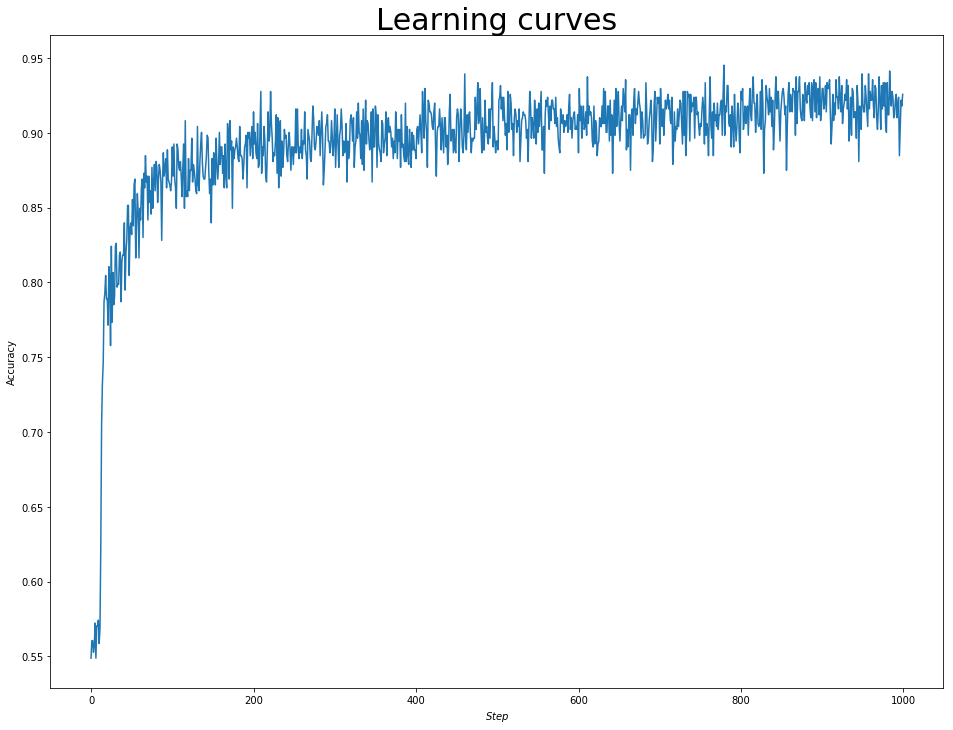

In [68]:
simple_plot(ah, 'Accuracy')

In [69]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [70]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [71]:
acc_test

0.8931133428981348

In [72]:
rec_test

0.9154228855721394

## analysis:
learning rate = 0.1, acc_test = 0.8931133428981348, rec_test = 0.9154228855721394 <br>
learning rate = 0.01, acc_test = 0.8106169296987088, rec_test = 0.9104477611940298 <br>
learning rate = 0.001, acc_test = 0.14562410329985653, rec_test = 1.0 <br>
As learning rate becomes smaller, accuracy seems to become smaller. There isn't a trend for recall score. 
Maybe this is because 

## Option 3: number of layers
Number of layers is set to be len(nn_architecture). We redefine nn_architecture to investigate different number of layers.

### part 1: number of layers = 3 <br>
add one more layer to NN_ARCHITECTURE.

In [119]:
WORD_EMB_DIM = X_train.shape[1]
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

In [120]:
import ipdb
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.01, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69712 - accuracy: 0.42941
Iteration: 00010 - cost: 0.68998 - accuracy: 0.56471
Iteration: 00020 - cost: 0.68645 - accuracy: 0.57059
Iteration: 00030 - cost: 0.68928 - accuracy: 0.54412
Iteration: 00040 - cost: 0.68935 - accuracy: 0.54412
Iteration: 00050 - cost: 0.68292 - accuracy: 0.57353
Iteration: 00060 - cost: 0.68129 - accuracy: 0.57941
Iteration: 00070 - cost: 0.68480 - accuracy: 0.56471
Iteration: 00080 - cost: 0.68017 - accuracy: 0.58235
Iteration: 00090 - cost: 0.68248 - accuracy: 0.57353
Iteration: 00100 - cost: 0.67849 - accuracy: 0.58824
Iteration: 00110 - cost: 0.68401 - accuracy: 0.56765
Iteration: 00120 - cost: 0.68643 - accuracy: 0.55882
Iteration: 00130 - cost: 0.68642 - accuracy: 0.55882
Iteration: 00140 - cost: 0.68561 - accuracy: 0.56176
Iteration: 00150 - cost: 0.68483 - accuracy: 0.56471
Iteration: 00160 - cost: 0.67999 - accuracy: 0.58235
Iteration: 00170 - cost: 0.68401 - accuracy: 0.56765
Iteration: 00180 - cost: 0.68400 - accuracy: 0

Iteration: 01560 - cost: 0.69029 - accuracy: 0.54412
Iteration: 01570 - cost: 0.68555 - accuracy: 0.56176
Iteration: 01580 - cost: 0.67601 - accuracy: 0.59706
Iteration: 01590 - cost: 0.68316 - accuracy: 0.57059
Iteration: 01600 - cost: 0.68956 - accuracy: 0.54706
Iteration: 01610 - cost: 0.68394 - accuracy: 0.56765
Iteration: 01620 - cost: 0.67840 - accuracy: 0.58824
Iteration: 01630 - cost: 0.68953 - accuracy: 0.54706
Iteration: 01640 - cost: 0.68395 - accuracy: 0.56765
Iteration: 01650 - cost: 0.68557 - accuracy: 0.56176
Iteration: 01660 - cost: 0.68801 - accuracy: 0.55294
Iteration: 01670 - cost: 0.68639 - accuracy: 0.55882
Iteration: 01680 - cost: 0.68476 - accuracy: 0.56471
Iteration: 01690 - cost: 0.68962 - accuracy: 0.54706
Iteration: 01700 - cost: 0.68316 - accuracy: 0.57059
Iteration: 01710 - cost: 0.67990 - accuracy: 0.58235
Iteration: 01720 - cost: 0.67914 - accuracy: 0.58529
Iteration: 01730 - cost: 0.68477 - accuracy: 0.56471
Iteration: 01740 - cost: 0.68397 - accuracy: 0

Iteration: 03130 - cost: 0.69029 - accuracy: 0.54412
Iteration: 03140 - cost: 0.68630 - accuracy: 0.55882
Iteration: 03150 - cost: 0.68310 - accuracy: 0.57059
Iteration: 03160 - cost: 0.67750 - accuracy: 0.59118
Iteration: 03170 - cost: 0.68551 - accuracy: 0.56176
Iteration: 03180 - cost: 0.68793 - accuracy: 0.55294
Iteration: 03190 - cost: 0.68310 - accuracy: 0.57059
Iteration: 03200 - cost: 0.67421 - accuracy: 0.60294
Iteration: 03210 - cost: 0.68471 - accuracy: 0.56471
Iteration: 03220 - cost: 0.68152 - accuracy: 0.57647
Iteration: 03230 - cost: 0.68390 - accuracy: 0.56765
Iteration: 03240 - cost: 0.68633 - accuracy: 0.55882
Iteration: 03250 - cost: 0.68550 - accuracy: 0.56176
Iteration: 03260 - cost: 0.68068 - accuracy: 0.57941
Iteration: 03270 - cost: 0.68388 - accuracy: 0.56765
Iteration: 03280 - cost: 0.68151 - accuracy: 0.57647
Iteration: 03290 - cost: 0.68230 - accuracy: 0.57353
Iteration: 03300 - cost: 0.68393 - accuracy: 0.56765
Iteration: 03310 - cost: 0.68551 - accuracy: 0

Iteration: 04700 - cost: 0.68137 - accuracy: 0.57647
Iteration: 04710 - cost: 0.68295 - accuracy: 0.57059
Iteration: 04720 - cost: 0.68540 - accuracy: 0.56176
Iteration: 04730 - cost: 0.68455 - accuracy: 0.56471
Iteration: 04740 - cost: 0.68141 - accuracy: 0.57647
Iteration: 04750 - cost: 0.67901 - accuracy: 0.58529
Iteration: 04760 - cost: 0.68377 - accuracy: 0.56765
Iteration: 04770 - cost: 0.67486 - accuracy: 0.60000
Iteration: 04780 - cost: 0.68134 - accuracy: 0.57647
Iteration: 04790 - cost: 0.68212 - accuracy: 0.57353
Iteration: 04800 - cost: 0.68301 - accuracy: 0.57059
Iteration: 04810 - cost: 0.69356 - accuracy: 0.53235
Iteration: 04820 - cost: 0.68623 - accuracy: 0.55882
Iteration: 04830 - cost: 0.68618 - accuracy: 0.55882
Iteration: 04840 - cost: 0.67411 - accuracy: 0.60294
Iteration: 04850 - cost: 0.68297 - accuracy: 0.57059
Iteration: 04860 - cost: 0.68295 - accuracy: 0.57059
Iteration: 04870 - cost: 0.67973 - accuracy: 0.58235
Iteration: 04880 - cost: 0.68698 - accuracy: 0

Iteration: 06250 - cost: 0.67696 - accuracy: 0.59118
Iteration: 06260 - cost: 0.68739 - accuracy: 0.55294
Iteration: 06270 - cost: 0.68188 - accuracy: 0.57353
Iteration: 06280 - cost: 0.68034 - accuracy: 0.57941
Iteration: 06290 - cost: 0.68343 - accuracy: 0.56765
Iteration: 06300 - cost: 0.68187 - accuracy: 0.57353
Iteration: 06310 - cost: 0.68350 - accuracy: 0.56765
Iteration: 06320 - cost: 0.68658 - accuracy: 0.55588
Iteration: 06330 - cost: 0.68581 - accuracy: 0.55882
Iteration: 06340 - cost: 0.68019 - accuracy: 0.57941
Iteration: 06350 - cost: 0.68010 - accuracy: 0.57941
Iteration: 06360 - cost: 0.68820 - accuracy: 0.55000
Iteration: 06370 - cost: 0.68665 - accuracy: 0.55588
Iteration: 06380 - cost: 0.68182 - accuracy: 0.57353
Iteration: 06390 - cost: 0.68424 - accuracy: 0.56471
Iteration: 06400 - cost: 0.68103 - accuracy: 0.57647
Iteration: 06410 - cost: 0.68566 - accuracy: 0.55882
Iteration: 06420 - cost: 0.68333 - accuracy: 0.56765
Iteration: 06430 - cost: 0.68266 - accuracy: 0

Iteration: 07820 - cost: 0.67693 - accuracy: 0.58529
Iteration: 07830 - cost: 0.68451 - accuracy: 0.55882
Iteration: 07840 - cost: 0.68272 - accuracy: 0.56765
Iteration: 07850 - cost: 0.67992 - accuracy: 0.57353
Iteration: 07860 - cost: 0.67925 - accuracy: 0.57647
Iteration: 07870 - cost: 0.68429 - accuracy: 0.55882
Iteration: 07880 - cost: 0.68114 - accuracy: 0.57059
Iteration: 07890 - cost: 0.68290 - accuracy: 0.56176
Iteration: 07900 - cost: 0.68788 - accuracy: 0.54412
Iteration: 07910 - cost: 0.68049 - accuracy: 0.57059
Iteration: 07920 - cost: 0.68823 - accuracy: 0.54412
Iteration: 07930 - cost: 0.67798 - accuracy: 0.58235
Iteration: 07940 - cost: 0.68403 - accuracy: 0.55882
Iteration: 07950 - cost: 0.68419 - accuracy: 0.55882
Iteration: 07960 - cost: 0.68318 - accuracy: 0.56176
Iteration: 07970 - cost: 0.68299 - accuracy: 0.56471
Iteration: 07980 - cost: 0.68848 - accuracy: 0.54412
Iteration: 07990 - cost: 0.68243 - accuracy: 0.56471
Iteration: 08000 - cost: 0.68484 - accuracy: 0

Iteration: 09400 - cost: 0.67249 - accuracy: 0.54412
Iteration: 09410 - cost: 0.66862 - accuracy: 0.55588
Iteration: 09420 - cost: 0.66697 - accuracy: 0.57353
Iteration: 09430 - cost: 0.66572 - accuracy: 0.57353
Iteration: 09440 - cost: 0.65535 - accuracy: 0.60588
Iteration: 09450 - cost: 0.66130 - accuracy: 0.58235
Iteration: 09460 - cost: 0.66066 - accuracy: 0.57941
Iteration: 09470 - cost: 0.66297 - accuracy: 0.57941
Iteration: 09480 - cost: 0.66344 - accuracy: 0.57353
Iteration: 09490 - cost: 0.66872 - accuracy: 0.55294
Iteration: 09500 - cost: 0.65780 - accuracy: 0.59412
Iteration: 09510 - cost: 0.66483 - accuracy: 0.57353
Iteration: 09520 - cost: 0.65865 - accuracy: 0.59412
Iteration: 09530 - cost: 0.66673 - accuracy: 0.55882
Iteration: 09540 - cost: 0.66492 - accuracy: 0.57059
Iteration: 09550 - cost: 0.66128 - accuracy: 0.57353
Iteration: 09560 - cost: 0.66058 - accuracy: 0.58235
Iteration: 09570 - cost: 0.66422 - accuracy: 0.57353
Iteration: 09580 - cost: 0.65711 - accuracy: 0

In [122]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [123]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [124]:
acc_test

0.336441893830703

In [125]:
rec_test

0.9888268156424581

#### part 2: number of layers = 4 <br>
add one more layer to NN_ARCHITECTURE.

In [127]:
WORD_EMB_DIM = X_train.shape[1]
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

In [128]:
import ipdb
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.01, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.71480 - accuracy: 0.42941
Iteration: 00010 - cost: 0.69698 - accuracy: 0.43529
Iteration: 00020 - cost: 0.68988 - accuracy: 0.57059
Iteration: 00030 - cost: 0.68959 - accuracy: 0.54412
Iteration: 00040 - cost: 0.68925 - accuracy: 0.54412
Iteration: 00050 - cost: 0.68323 - accuracy: 0.57353
Iteration: 00060 - cost: 0.68151 - accuracy: 0.57941
Iteration: 00070 - cost: 0.68477 - accuracy: 0.56471
Iteration: 00080 - cost: 0.68021 - accuracy: 0.58235
Iteration: 00090 - cost: 0.68245 - accuracy: 0.57353
Iteration: 00100 - cost: 0.67845 - accuracy: 0.58824
Iteration: 00110 - cost: 0.68397 - accuracy: 0.56765
Iteration: 00120 - cost: 0.68637 - accuracy: 0.55882
Iteration: 00130 - cost: 0.68640 - accuracy: 0.55882
Iteration: 00140 - cost: 0.68558 - accuracy: 0.56176
Iteration: 00150 - cost: 0.68477 - accuracy: 0.56471
Iteration: 00160 - cost: 0.67994 - accuracy: 0.58235
Iteration: 00170 - cost: 0.68397 - accuracy: 0.56765
Iteration: 00180 - cost: 0.68397 - accuracy: 0

Iteration: 01560 - cost: 0.69031 - accuracy: 0.54412
Iteration: 01570 - cost: 0.68556 - accuracy: 0.56176
Iteration: 01580 - cost: 0.67596 - accuracy: 0.59706
Iteration: 01590 - cost: 0.68316 - accuracy: 0.57059
Iteration: 01600 - cost: 0.68956 - accuracy: 0.54706
Iteration: 01610 - cost: 0.68397 - accuracy: 0.56765
Iteration: 01620 - cost: 0.67839 - accuracy: 0.58824
Iteration: 01630 - cost: 0.68955 - accuracy: 0.54706
Iteration: 01640 - cost: 0.68397 - accuracy: 0.56765
Iteration: 01650 - cost: 0.68559 - accuracy: 0.56176
Iteration: 01660 - cost: 0.68804 - accuracy: 0.55294
Iteration: 01670 - cost: 0.68641 - accuracy: 0.55882
Iteration: 01680 - cost: 0.68478 - accuracy: 0.56471
Iteration: 01690 - cost: 0.68965 - accuracy: 0.54706
Iteration: 01700 - cost: 0.68316 - accuracy: 0.57059
Iteration: 01710 - cost: 0.67990 - accuracy: 0.58235
Iteration: 01720 - cost: 0.67915 - accuracy: 0.58529
Iteration: 01730 - cost: 0.68476 - accuracy: 0.56471
Iteration: 01740 - cost: 0.68397 - accuracy: 0

Iteration: 03120 - cost: 0.68956 - accuracy: 0.54706
Iteration: 03130 - cost: 0.69036 - accuracy: 0.54412
Iteration: 03140 - cost: 0.68637 - accuracy: 0.55882
Iteration: 03150 - cost: 0.68316 - accuracy: 0.57059
Iteration: 03160 - cost: 0.67757 - accuracy: 0.59118
Iteration: 03170 - cost: 0.68557 - accuracy: 0.56176
Iteration: 03180 - cost: 0.68801 - accuracy: 0.55294
Iteration: 03190 - cost: 0.68316 - accuracy: 0.57059
Iteration: 03200 - cost: 0.67428 - accuracy: 0.60294
Iteration: 03210 - cost: 0.68479 - accuracy: 0.56471
Iteration: 03220 - cost: 0.68156 - accuracy: 0.57647
Iteration: 03230 - cost: 0.68397 - accuracy: 0.56765
Iteration: 03240 - cost: 0.68639 - accuracy: 0.55882
Iteration: 03250 - cost: 0.68556 - accuracy: 0.56176
Iteration: 03260 - cost: 0.68078 - accuracy: 0.57941
Iteration: 03270 - cost: 0.68397 - accuracy: 0.56765
Iteration: 03280 - cost: 0.68157 - accuracy: 0.57647
Iteration: 03290 - cost: 0.68237 - accuracy: 0.57353
Iteration: 03300 - cost: 0.68397 - accuracy: 0

Iteration: 04700 - cost: 0.68153 - accuracy: 0.57647
Iteration: 04710 - cost: 0.68316 - accuracy: 0.57059
Iteration: 04720 - cost: 0.68557 - accuracy: 0.56176
Iteration: 04730 - cost: 0.68477 - accuracy: 0.56471
Iteration: 04740 - cost: 0.68155 - accuracy: 0.57647
Iteration: 04750 - cost: 0.67917 - accuracy: 0.58529
Iteration: 04760 - cost: 0.68397 - accuracy: 0.56765
Iteration: 04770 - cost: 0.67510 - accuracy: 0.60000
Iteration: 04780 - cost: 0.68155 - accuracy: 0.57647
Iteration: 04790 - cost: 0.68235 - accuracy: 0.57353
Iteration: 04800 - cost: 0.68316 - accuracy: 0.57059
Iteration: 04810 - cost: 0.69373 - accuracy: 0.53235
Iteration: 04820 - cost: 0.68642 - accuracy: 0.55882
Iteration: 04830 - cost: 0.68641 - accuracy: 0.55882
Iteration: 04840 - cost: 0.67430 - accuracy: 0.60294
Iteration: 04850 - cost: 0.68316 - accuracy: 0.57059
Iteration: 04860 - cost: 0.68316 - accuracy: 0.57059
Iteration: 04870 - cost: 0.67994 - accuracy: 0.58235
Iteration: 04880 - cost: 0.68721 - accuracy: 0

Iteration: 06280 - cost: 0.68078 - accuracy: 0.57941
Iteration: 06290 - cost: 0.68397 - accuracy: 0.56765
Iteration: 06300 - cost: 0.68237 - accuracy: 0.57353
Iteration: 06310 - cost: 0.68397 - accuracy: 0.56765
Iteration: 06320 - cost: 0.68715 - accuracy: 0.55588
Iteration: 06330 - cost: 0.68637 - accuracy: 0.55882
Iteration: 06340 - cost: 0.68079 - accuracy: 0.57941
Iteration: 06350 - cost: 0.68075 - accuracy: 0.57941
Iteration: 06360 - cost: 0.68881 - accuracy: 0.55000
Iteration: 06370 - cost: 0.68716 - accuracy: 0.55588
Iteration: 06380 - cost: 0.68239 - accuracy: 0.57353
Iteration: 06390 - cost: 0.68476 - accuracy: 0.56471
Iteration: 06400 - cost: 0.68158 - accuracy: 0.57647
Iteration: 06410 - cost: 0.68636 - accuracy: 0.55882
Iteration: 06420 - cost: 0.68397 - accuracy: 0.56765
Iteration: 06430 - cost: 0.68317 - accuracy: 0.57059
Iteration: 06440 - cost: 0.69040 - accuracy: 0.54412
Iteration: 06450 - cost: 0.68792 - accuracy: 0.55294
Iteration: 06460 - cost: 0.68238 - accuracy: 0

Iteration: 07830 - cost: 0.68639 - accuracy: 0.55882
Iteration: 07840 - cost: 0.68397 - accuracy: 0.56765
Iteration: 07850 - cost: 0.68237 - accuracy: 0.57353
Iteration: 07860 - cost: 0.68157 - accuracy: 0.57647
Iteration: 07870 - cost: 0.68634 - accuracy: 0.55882
Iteration: 07880 - cost: 0.68318 - accuracy: 0.57059
Iteration: 07890 - cost: 0.68555 - accuracy: 0.56176
Iteration: 07900 - cost: 0.69023 - accuracy: 0.54412
Iteration: 07910 - cost: 0.68318 - accuracy: 0.57059
Iteration: 07920 - cost: 0.69035 - accuracy: 0.54412
Iteration: 07930 - cost: 0.67999 - accuracy: 0.58235
Iteration: 07940 - cost: 0.68637 - accuracy: 0.55882
Iteration: 07950 - cost: 0.68640 - accuracy: 0.55882
Iteration: 07960 - cost: 0.68559 - accuracy: 0.56176
Iteration: 07970 - cost: 0.68477 - accuracy: 0.56471
Iteration: 07980 - cost: 0.69040 - accuracy: 0.54412
Iteration: 07990 - cost: 0.68477 - accuracy: 0.56471
Iteration: 08000 - cost: 0.68719 - accuracy: 0.55588
Iteration: 08010 - cost: 0.69040 - accuracy: 0

Iteration: 09390 - cost: 0.67919 - accuracy: 0.58529
Iteration: 09400 - cost: 0.69037 - accuracy: 0.54412
Iteration: 09410 - cost: 0.68717 - accuracy: 0.55588
Iteration: 09420 - cost: 0.68238 - accuracy: 0.57353
Iteration: 09430 - cost: 0.68236 - accuracy: 0.57353
Iteration: 09440 - cost: 0.67347 - accuracy: 0.60588
Iteration: 09450 - cost: 0.67992 - accuracy: 0.58235
Iteration: 09460 - cost: 0.68070 - accuracy: 0.57941
Iteration: 09470 - cost: 0.68070 - accuracy: 0.57941
Iteration: 09480 - cost: 0.68236 - accuracy: 0.57353
Iteration: 09490 - cost: 0.68794 - accuracy: 0.55294
Iteration: 09500 - cost: 0.67675 - accuracy: 0.59412
Iteration: 09510 - cost: 0.68236 - accuracy: 0.57353
Iteration: 09520 - cost: 0.67675 - accuracy: 0.59412
Iteration: 09530 - cost: 0.68637 - accuracy: 0.55882
Iteration: 09540 - cost: 0.68317 - accuracy: 0.57059
Iteration: 09550 - cost: 0.68237 - accuracy: 0.57353
Iteration: 09560 - cost: 0.67997 - accuracy: 0.58235
Iteration: 09570 - cost: 0.68234 - accuracy: 0

In [129]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [130]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [131]:
acc_test

0.1284074605451937

In [132]:
rec_test

1.0

## analysis:
number of layers = 2, acc_test = 0.8106169296987088, rec_test = 0.9104477611940298 <br>
number of layers = 3, acc_test = 0.336441893830703, rec_test = 0.9888268156424581  <br>
number of layers = 4, acc_test = 0.1284074605451937, rec_test = 1.0 <br>
The more layers there are, the less accurate it is. There isn't quite a trend for recall score. <br>


I found some explanation online about the relation between number of layers and accuracy. 
Basically, no hidden layer can only represent a linearly separable functions. 
A NN with a single hidden layer can fit majority of the models. We rarely need more than 1 hidden layer. So maybe going for more than 2 layers are not necessary and is not the right way to go!

https://www.quora.com/Is-accuracy-proportional-to-the-number-of-the-hidden-layers-and-the-units-of-the-each-layer-in-Neural-Network

## option 4: oversampling ratio
The oversampling ratio is determined by the number dividing "batch_size" , so if we choose "batch_size//3" we are oversampling a smaller portion of spam_ids.
We change batch_size to be 3.

In [102]:
#redefine the train function by changing batch size
def train(X, Y, nn_architecture, epochs, learning_rate, batch_size=128, verbose=False, callback=None, spam_ids=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    num_samples = X.shape[1]
    num_minibatches = int(X.shape[1] / batch_size)
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        for j in range(num_minibatches):
            # step forward
            inds = np.random.choice(X.shape[1], batch_size // 3)
            if spam_ids is not None:
                # oversampling minor class
                inds_spam = np.random.choice(spam_ids.shape[0], batch_size // 3)
                inds_spam = spam_ids[inds_spam]
                inds = np.concatenate((inds, inds_spam))
            Y_hat, cashe = full_forward_propagation(X[:,inds], params_values, nn_architecture)

            # step backward - calculating gradient
            grads_values = full_backward_propagation(Y_hat, Y[:, inds], cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        if(i % 10 == 0):
            # calculating metrics and saving them in history
            cost = get_cost_value(Y_hat, Y[:,inds])
            accuracy = get_accuracy_value(Y_hat, Y[:, inds])
            cost_history.append(cost)
            accuracy_history.append(accuracy)

            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

# Text classification

In [103]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# install nltk if needed
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
stemmer = SnowballStemmer("english")

## Text classification: variable length input!

In [104]:
# lets load some data first

spam_data = pickle.load(open('spam.pkl', 'rb'))
spam_data_input = [i[0] for i in spam_data]
cleaned_spam_data_input = []
one_line_data = []
for sent in spam_data_input:
    toked = word_tokenize(sent)
    stemmed = []
    for token in toked:
        stemmed.append(stemmer.stem(token))
    cleaned_spam_data_input.append(' '.join(stemmed))
    one_line_data.append(stemmed)
    

spam_data_label = [i[1] for i in spam_data]

_X_train, _X_test, _y_train, _y_test = train_test_split(cleaned_spam_data_input, spam_data_label)

## Quick intro to Word2Vec

In [105]:
import gensim 
from gensim.models import Word2Vec

vectors = Word2Vec(one_line_data, min_count=0)
vectors.train(cleaned_spam_data_input, total_examples=len(cleaned_spam_data_input), epochs=10)
vecs = vectors.wv

## Lets check some word similarities

In [106]:
def get_word_similarity(s):
    print('sim({}) = {}'.format(s, vectors.similarity(s.split()[0], s.split()[1])))

In [107]:
WORD_EMB_DIM = 300
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 128, "activation": "sigmoid"},
    {"input_dim": 128, "output_dim": 128, "activation": "sigmoid"},
    {"input_dim": 128, "output_dim": 1, "activation": "sigmoid"},
]

## Convert text input data into the bag of words

Simply speaking, we take fixed dim embedding of every token in the sentence and average them all!

In [108]:
vector_based_spam_input = []
for sent in one_line_data:
    _tmp = []
    for w in sent:
        try:
            _tmp.append(vecs.get_vector(w))
        except:
            pass
    if len(_tmp) == 0:
        import ipdb; ipdb.set_trace()
    _avg = np.array(_tmp).mean(0)
    vector_based_spam_input.append(_avg)

In [109]:
print(cleaned_spam_data_input[3324])
print(vector_based_spam_input[3324])

she said , '' do u mind if i go into the bedroom for a minut ? `` 'ok '' , i sed in a sexi mood . she came out 5 minut latr wid a cake ... n my wife ,
[ 0.23664635 -0.22822349  0.2179251  -0.604111   -1.0977399  -0.3625957
 -0.32383245 -0.3082502   0.06003264  0.07134861  0.63856906  0.55679905
  0.11261989 -0.27654845 -0.80116683 -0.94183785  0.00641062  0.86094826
 -0.65122074  0.36357468 -0.76005185  0.2046047  -0.00394253  1.0771189
  0.45350707 -0.3523671  -0.4367836   0.9356216   0.21157905 -0.21332696
 -0.60293937  0.0503982  -0.0922726  -1.2229555  -0.32253185 -1.1373551
  0.2815579   0.6522309  -0.6254478   0.19580857  0.37875047 -0.27903417
  0.4865758   0.5347865  -0.7247621   0.3827907   0.37131083 -0.3964608
  0.79102236  0.51626694 -0.66072667  0.18359073 -0.225854    0.32404545
  0.07667733 -0.42600468 -0.03175848  0.48127392 -0.4284659   0.2335567
 -0.55590296 -1.0370901   0.01915698  0.12744612 -0.01046859  0.00574677
 -0.18403928 -0.05057098 -0.24746168  0.12671657  0

In [110]:
_X_train, _X_test, _y_train, _y_test = train_test_split(vector_based_spam_input, spam_data_label)

In [111]:
X_train = np.array(_X_train)
X_test = np.array(_X_test)
y_train = np.array(_y_train)
y_test = np.array(_y_test)

y_train_spam_ids = (y_train == 1).nonzero()[0]

In [112]:
WORD_EMB_DIM = X_train.shape[1]
NN_ARCHITECTURE = [
    {"input_dim": WORD_EMB_DIM, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

In [113]:
import ipdb
params_values, ch, ah = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, epochs=10000, learning_rate=0.01, batch_size=512, verbose=True, spam_ids=y_train_spam_ids)

Iteration: 00000 - cost: 0.69525 - accuracy: 0.39118
Iteration: 00010 - cost: 0.68874 - accuracy: 0.57647
Iteration: 00020 - cost: 0.68822 - accuracy: 0.56176
Iteration: 00030 - cost: 0.68446 - accuracy: 0.57647
Iteration: 00040 - cost: 0.68693 - accuracy: 0.55882
Iteration: 00050 - cost: 0.68388 - accuracy: 0.57353
Iteration: 00060 - cost: 0.68191 - accuracy: 0.57941
Iteration: 00070 - cost: 0.68560 - accuracy: 0.56471
Iteration: 00080 - cost: 0.68088 - accuracy: 0.58235
Iteration: 00090 - cost: 0.68318 - accuracy: 0.57353
Iteration: 00100 - cost: 0.67938 - accuracy: 0.58824
Iteration: 00110 - cost: 0.68456 - accuracy: 0.56765
Iteration: 00120 - cost: 0.68699 - accuracy: 0.55882
Iteration: 00130 - cost: 0.68661 - accuracy: 0.55882
Iteration: 00140 - cost: 0.68594 - accuracy: 0.56176
Iteration: 00150 - cost: 0.68528 - accuracy: 0.56471
Iteration: 00160 - cost: 0.68028 - accuracy: 0.58235
Iteration: 00170 - cost: 0.68410 - accuracy: 0.56765
Iteration: 00180 - cost: 0.68399 - accuracy: 0

Iteration: 01590 - cost: 0.58099 - accuracy: 0.78529
Iteration: 01600 - cost: 0.59948 - accuracy: 0.77647
Iteration: 01610 - cost: 0.55067 - accuracy: 0.79706
Iteration: 01620 - cost: 0.58638 - accuracy: 0.77941
Iteration: 01630 - cost: 0.60376 - accuracy: 0.76176
Iteration: 01640 - cost: 0.58457 - accuracy: 0.77353
Iteration: 01650 - cost: 0.58600 - accuracy: 0.76176
Iteration: 01660 - cost: 0.58285 - accuracy: 0.77941
Iteration: 01670 - cost: 0.60105 - accuracy: 0.72941
Iteration: 01680 - cost: 0.56562 - accuracy: 0.77647
Iteration: 01690 - cost: 0.56565 - accuracy: 0.79412
Iteration: 01700 - cost: 0.57372 - accuracy: 0.79118
Iteration: 01710 - cost: 0.58909 - accuracy: 0.75588
Iteration: 01720 - cost: 0.57400 - accuracy: 0.80294
Iteration: 01730 - cost: 0.59424 - accuracy: 0.74706
Iteration: 01740 - cost: 0.57308 - accuracy: 0.77353
Iteration: 01750 - cost: 0.59050 - accuracy: 0.74412
Iteration: 01760 - cost: 0.55375 - accuracy: 0.76765
Iteration: 01770 - cost: 0.58950 - accuracy: 0

Iteration: 03180 - cost: 0.43571 - accuracy: 0.81471
Iteration: 03190 - cost: 0.43593 - accuracy: 0.81471
Iteration: 03200 - cost: 0.46122 - accuracy: 0.81176
Iteration: 03210 - cost: 0.43969 - accuracy: 0.81471
Iteration: 03220 - cost: 0.46486 - accuracy: 0.79118
Iteration: 03230 - cost: 0.46670 - accuracy: 0.79412
Iteration: 03240 - cost: 0.45928 - accuracy: 0.79412
Iteration: 03250 - cost: 0.46501 - accuracy: 0.77647
Iteration: 03260 - cost: 0.44196 - accuracy: 0.81765
Iteration: 03270 - cost: 0.42076 - accuracy: 0.80588
Iteration: 03280 - cost: 0.45094 - accuracy: 0.80882
Iteration: 03290 - cost: 0.42725 - accuracy: 0.83529
Iteration: 03300 - cost: 0.48973 - accuracy: 0.75000
Iteration: 03310 - cost: 0.43954 - accuracy: 0.80882
Iteration: 03320 - cost: 0.44215 - accuracy: 0.80294
Iteration: 03330 - cost: 0.44130 - accuracy: 0.79706
Iteration: 03340 - cost: 0.45157 - accuracy: 0.79118
Iteration: 03350 - cost: 0.46779 - accuracy: 0.79412
Iteration: 03360 - cost: 0.44193 - accuracy: 0

Iteration: 04730 - cost: 0.36234 - accuracy: 0.85882
Iteration: 04740 - cost: 0.36535 - accuracy: 0.82941
Iteration: 04750 - cost: 0.41121 - accuracy: 0.80294
Iteration: 04760 - cost: 0.36740 - accuracy: 0.85294
Iteration: 04770 - cost: 0.33248 - accuracy: 0.86765
Iteration: 04780 - cost: 0.35197 - accuracy: 0.87353
Iteration: 04790 - cost: 0.35257 - accuracy: 0.88824
Iteration: 04800 - cost: 0.41839 - accuracy: 0.81176
Iteration: 04810 - cost: 0.42670 - accuracy: 0.78824
Iteration: 04820 - cost: 0.40293 - accuracy: 0.80588
Iteration: 04830 - cost: 0.36526 - accuracy: 0.85882
Iteration: 04840 - cost: 0.38414 - accuracy: 0.82353
Iteration: 04850 - cost: 0.40719 - accuracy: 0.84412
Iteration: 04860 - cost: 0.35392 - accuracy: 0.86765
Iteration: 04870 - cost: 0.37405 - accuracy: 0.85588
Iteration: 04880 - cost: 0.36762 - accuracy: 0.84118
Iteration: 04890 - cost: 0.39331 - accuracy: 0.81765
Iteration: 04900 - cost: 0.38277 - accuracy: 0.83529
Iteration: 04910 - cost: 0.36912 - accuracy: 0

Iteration: 06280 - cost: 0.36233 - accuracy: 0.85588
Iteration: 06290 - cost: 0.35877 - accuracy: 0.85882
Iteration: 06300 - cost: 0.34950 - accuracy: 0.85588
Iteration: 06310 - cost: 0.37873 - accuracy: 0.82647
Iteration: 06320 - cost: 0.36387 - accuracy: 0.85882
Iteration: 06330 - cost: 0.39106 - accuracy: 0.83824
Iteration: 06340 - cost: 0.34778 - accuracy: 0.86176
Iteration: 06350 - cost: 0.37122 - accuracy: 0.85294
Iteration: 06360 - cost: 0.40152 - accuracy: 0.82941
Iteration: 06370 - cost: 0.36900 - accuracy: 0.85588
Iteration: 06380 - cost: 0.33920 - accuracy: 0.84706
Iteration: 06390 - cost: 0.35029 - accuracy: 0.87647
Iteration: 06400 - cost: 0.31639 - accuracy: 0.85882
Iteration: 06410 - cost: 0.32246 - accuracy: 0.87941
Iteration: 06420 - cost: 0.35766 - accuracy: 0.85294
Iteration: 06430 - cost: 0.38334 - accuracy: 0.85294
Iteration: 06440 - cost: 0.37133 - accuracy: 0.84412
Iteration: 06450 - cost: 0.34754 - accuracy: 0.85882
Iteration: 06460 - cost: 0.38822 - accuracy: 0

Iteration: 07860 - cost: 0.31518 - accuracy: 0.87647
Iteration: 07870 - cost: 0.35886 - accuracy: 0.85000
Iteration: 07880 - cost: 0.36752 - accuracy: 0.84706
Iteration: 07890 - cost: 0.33832 - accuracy: 0.88529
Iteration: 07900 - cost: 0.34052 - accuracy: 0.87647
Iteration: 07910 - cost: 0.36602 - accuracy: 0.86765
Iteration: 07920 - cost: 0.37204 - accuracy: 0.85882
Iteration: 07930 - cost: 0.34436 - accuracy: 0.85294
Iteration: 07940 - cost: 0.38015 - accuracy: 0.86471
Iteration: 07950 - cost: 0.31221 - accuracy: 0.87941
Iteration: 07960 - cost: 0.34931 - accuracy: 0.87941
Iteration: 07970 - cost: 0.32038 - accuracy: 0.89118
Iteration: 07980 - cost: 0.38710 - accuracy: 0.82647
Iteration: 07990 - cost: 0.31873 - accuracy: 0.86176
Iteration: 08000 - cost: 0.35795 - accuracy: 0.85882
Iteration: 08010 - cost: 0.36947 - accuracy: 0.85294
Iteration: 08020 - cost: 0.35921 - accuracy: 0.85588
Iteration: 08030 - cost: 0.34996 - accuracy: 0.86765
Iteration: 08040 - cost: 0.35700 - accuracy: 0

Iteration: 09410 - cost: 0.33129 - accuracy: 0.86471
Iteration: 09420 - cost: 0.32656 - accuracy: 0.87941
Iteration: 09430 - cost: 0.31345 - accuracy: 0.88824
Iteration: 09440 - cost: 0.31183 - accuracy: 0.87059
Iteration: 09450 - cost: 0.30963 - accuracy: 0.87059
Iteration: 09460 - cost: 0.32575 - accuracy: 0.85294
Iteration: 09470 - cost: 0.33054 - accuracy: 0.85000
Iteration: 09480 - cost: 0.40528 - accuracy: 0.84118
Iteration: 09490 - cost: 0.33886 - accuracy: 0.84706
Iteration: 09500 - cost: 0.29656 - accuracy: 0.86765
Iteration: 09510 - cost: 0.30920 - accuracy: 0.88235
Iteration: 09520 - cost: 0.32688 - accuracy: 0.88824
Iteration: 09530 - cost: 0.37652 - accuracy: 0.84118
Iteration: 09540 - cost: 0.33062 - accuracy: 0.85000
Iteration: 09550 - cost: 0.32355 - accuracy: 0.85882
Iteration: 09560 - cost: 0.38497 - accuracy: 0.84412
Iteration: 09570 - cost: 0.36274 - accuracy: 0.85588
Iteration: 09580 - cost: 0.31699 - accuracy: 0.88235
Iteration: 09590 - cost: 0.38584 - accuracy: 0

## Some plots

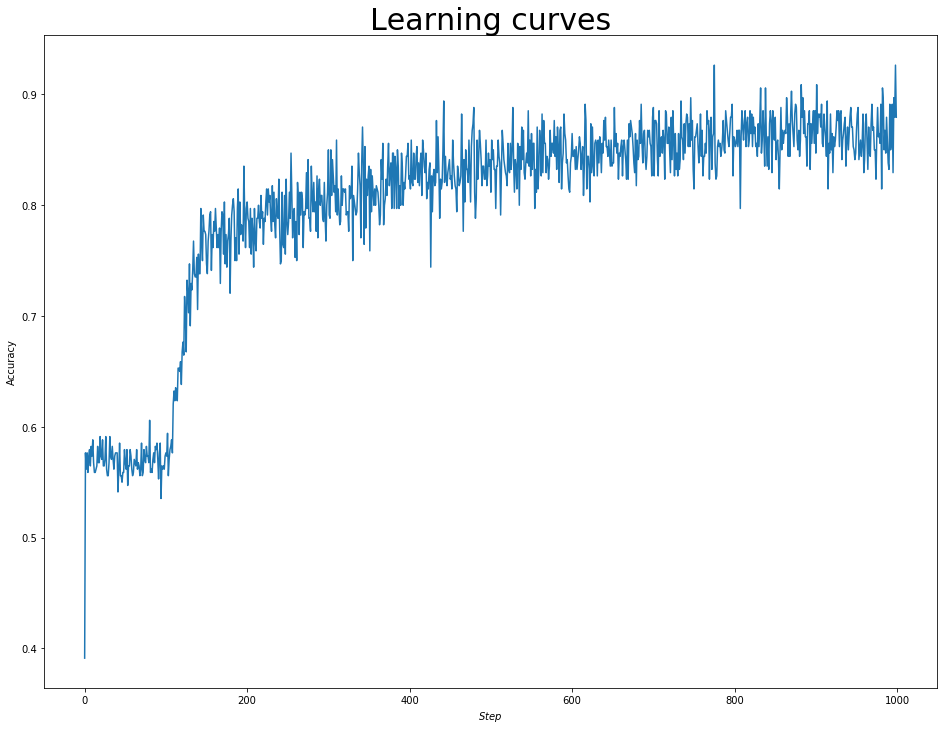

In [114]:
def simple_plot(metric, name):
    x_axis = np.arange(len(metric))
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Step$", ylabel=name)
    plt.title("Learning curves", fontsize=30)
    plt.plot(x_axis, np.array(ah))
    plt.show

simple_plot(ah, 'Accuracy')

In [115]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [116]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
rec_test = get_recall_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))

In [117]:
acc_test

0.8170731707317073

In [118]:
rec_test

0.88268156424581

## analysis:
batch_size//2, acc_test = 0.8106169296987088, rec_test = 0.9104477611940298 <br>
batch_size//3, acc_test = 0.8170731707317073, rec_test = 0.88268156424581 <br>
The oversampling ratio is determined by the number dividing "batch_size" , so if we choose "batch_size//3" we are oversampling a smaller portion of spam_ids. In this way we could get a higher accuracy.

